Later change this notebook to just extraction of dft data to dataframe

In [1]:
from futile import YamlIO as Y
from futile.Utils import ensure_dir, write
from BigDFT import Calculators as C
from BigDFT import Logfiles as lf
from BigDFT import Inputfiles as I,InputActions as A

import constants as const
# # import plotting_wrappers
# import excited_states
# import utilities as utils

import shutil
import os
import numpy as np
import pandas as pd
from IPython.display import display
import pickle as pkl
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import pickle

In [2]:
Ha2eV = const.Ha2eV

In [7]:
# original molecules
data_og_mols = {}
data_og_mols['Mol_names'] = []
data_og_mols['log file'] = []
data_og_mols['HOMO'] = []
data_og_mols['LUMO'] = []
data_og_mols['LUMO-HOMO'] = []
data_og_mols['Force'] = []
data_og_mols['Total Energy per atom (eV/atom)'] = []

og_mols = ['TUFWAS','YAFNOI','GOBVUP','TXO-TPA','TXO-PhCz','PXZ-TRZ']

og_dir = '20_mols_benchmark/'

for file in os.listdir(og_dir):
    if 'log-' in file and 'MMFF94' in file:
        for mol in og_mols:
            if mol+'_PBE' in file:

                log = lf.Logfile(og_dir+file)
                
                name = file.replace('log-','').split('_')[0]

                final_gnrm = log.log['Ground State Optimization'][-1]['Hamiltonian Optimization'][-1]\
                    ['Subspace Optimization']['Wavefunctions Iterations'][-1]['gnrm']
                target_gnrm = log.log['dft']['gnrm_cv']

                if final_gnrm > float(target_gnrm):

                    data_og_mols['Mol_names'].append(name)
                    data_og_mols['log file'].append(file)


                    #converged = False
                    print(file, 'WARNING, calculation did not converge')
                    data_og_mols['HOMO'].append(float('nan'))
                    data_og_mols['LUMO'].append(float('nan'))
                    data_og_mols['LUMO-HOMO'].append(float('nan'))
                    data_og_mols['Force'].append(float('nan'))
                    data_og_mols['Total Energy per atom (eV/atom)'].append(float('nan'))

                else:

                    data_og_mols['Mol_names'].append(name)
                    data_og_mols['log file'].append(file)

                    tot_electrons = log.log['Total Number of Electrons']
                #     tot_orbs = log.log['Total Number of Orbitals'] # this include virtuals
                    tot_orbs = int(tot_electrons / 2)
#                     print(tot_orbs,log.evals[0][0][2])
                    homo = log.evals[0][0][tot_orbs-1] * Ha2eV
                    lumo = log.evals[0][0][tot_orbs] * Ha2eV


                    data_og_mols['HOMO'].append(homo)
                    data_og_mols['LUMO'].append(lumo)
                    data_og_mols['LUMO-HOMO'].append(lumo-homo)
                    data_og_mols['Force'].append(log.log['Force Norm (Hartree/Bohr)'])
                    data_og_mols['Total Energy per atom (eV/atom)'].append((log.energy/log.nat) * Ha2eV)

In [8]:
df_og_syba = pickle.load(open("df_og_data.pkl",'rb'))
df_og_syba

Family                                             SMILES Mol_names  \
0   PXZ-TRZ  c7ccc(c6nc(c1ccccc1)nc(c5ccc(n4c2ccccc2oc3cccc...   PXZ-TRZ   
1  TXO-PhCz  O=C6c1ccccc1S(=O)(=O)c7ccc(c2ccc4c(c2)c3ccccc3...  TXO-PhCz   
2   TXO-TPA  O=C5c1ccccc1S(=O)(=O)c6ccc(c4ccc(N(c2ccccc2)c3...   TXO-TPA   
3    GOBVUP        Clc4ccc(c3csc(=c2scc(c1ccc(Cl)cc1)s2)s3)cc4    GOBVUP   
4    TUFWAS  c6csc(c4sc(=c3sc(c1cccs1)c(c2cccs2)s3)sc4c5ccc...    TUFWAS   
5    YAFNOI            c1ccc3c(c1)c2ccccc2S36c4ccccc4c5ccccc56    YAFNOI   

   fp_scores  SYBA_score  natoms  
0          1   36.220805      38  
1          1   27.806475      36  
2          1   49.425950      36  
3          1   -2.196499      24  
4          1   18.543954      30  
5          1   18.541930      25

HL overlap

In [9]:
df_og_HL = pickle.load(open("data_HL_overlap_parent_mols.pkl",'rb'))
df_og_HL.rename(columns={"$\Lambda_{\mathrm{T}}$":"LambdaT"},inplace = True)
df_og_HL = df_og_HL.reindex([5,0,3,1,2,4])
df_og_HL

Mol_names   LambdaT  N_atoms                                     log file  \
5   PXZ-TRZ  0.107584       60   log-PXZ-TRZ_PBE_MMFF94_s0xyz_s0_cubic.yaml   
0  TXO-PhCz  0.148074       55  log-TXO-PhCz_PBE_MMFF94_s0xyz_s0_cubic.yaml   
3   TXO-TPA  0.124097       57   log-TXO-TPA_PBE_MMFF94_s0xyz_s0_cubic.yaml   
1    GOBVUP  0.551026       34    log-GOBVUP_PBE_MMFF94_s0xyz_s0_cubic.yaml   
2    TUFWAS  0.557252       42    log-TUFWAS_PBE_MMFF94_s0xyz_s0_cubic.yaml   
4    YAFNOI  0.843576       41    log-YAFNOI_PBE_MMFF94_s0xyz_s0_cubic.yaml   

       HOMO      LUMO  LUMO-HOMO     Force  Total Energy per atom (eV/atom)  
5 -4.317159 -3.070328   1.246831  0.059228                      -130.845350  
0 -5.218214 -3.504901   1.713312  0.078844                      -143.889830  
3 -4.844501 -3.538314   1.306187  0.052497                      -139.398779  
1 -3.955886 -2.220191   1.735695  0.041024                      -190.182191  
2 -3.866078 -2.294039   1.572039  0.067476                      -181.225573  
4 -2.800095 -2.726797   0.073298  0.186780                      -121.536756

max force example

In [10]:
log = lf.Logfile('20_mols_benchmark/log-PXZ-TRZ_PBE_MMFF94_s0xyz_s0_cubic.yaml')

In [13]:
df_og = pd.merge(df_og_HL,df_og_syba)
print(df_og.columns)
df_og

Index(['Mol_names', 'LambdaT', 'N_atoms', 'log file', 'HOMO', 'LUMO',
       'LUMO-HOMO', 'Force', 'Total Energy per atom (eV/atom)', 'Family',
       'SMILES', 'fp_scores', 'SYBA_score', 'natoms'],
      dtype='object')


Mol_names   LambdaT  N_atoms                                     log file  \
0   PXZ-TRZ  0.107584       60   log-PXZ-TRZ_PBE_MMFF94_s0xyz_s0_cubic.yaml   
1  TXO-PhCz  0.148074       55  log-TXO-PhCz_PBE_MMFF94_s0xyz_s0_cubic.yaml   
2   TXO-TPA  0.124097       57   log-TXO-TPA_PBE_MMFF94_s0xyz_s0_cubic.yaml   
3    GOBVUP  0.551026       34    log-GOBVUP_PBE_MMFF94_s0xyz_s0_cubic.yaml   
4    TUFWAS  0.557252       42    log-TUFWAS_PBE_MMFF94_s0xyz_s0_cubic.yaml   
5    YAFNOI  0.843576       41    log-YAFNOI_PBE_MMFF94_s0xyz_s0_cubic.yaml   

       HOMO      LUMO  LUMO-HOMO     Force  Total Energy per atom (eV/atom)  \
0 -4.317159 -3.070328   1.246831  0.059228                      -130.845350   
1 -5.218214 -3.504901   1.713312  0.078844                      -143.889830   
2 -4.844501 -3.538314   1.306187  0.052497                      -139.398779   
3 -3.955886 -2.220191   1.735695  0.041024                      -190.182191   
4 -3.866078 -2.294039   1.572039  0.067476                      -181.225573   
5 -2.800095 -2.726797   0.073298  0.186780                      -121.536756   

     Family                                             SMILES  fp_scores  \
0   PXZ-TRZ  c7ccc(c6nc(c1ccccc1)nc(c5ccc(n4c2ccccc2oc3cccc...          1   
1  TXO-PhCz  O=C6c1ccccc1S(=O)(=O)c7ccc(c2ccc4c(c2)c3ccccc3...          1   
2   TXO-TPA  O=C5c1ccccc1S(=O)(=O)c6ccc(c4ccc(N(c2ccccc2)c3...          1   
3    GOBVUP        Clc4ccc(c3csc(=c2scc(c1ccc(Cl)cc1)s2)s3)cc4          1   
4    TUFWAS  c6csc(c4sc(=c3sc(c1cccs1)c(c2cccs2)s3)sc4c5ccc...          1   
5    YAFNOI            c1ccc3c(c1)c2ccccc2S36c4ccccc4c5ccccc56          1   

   SYBA_score  natoms  
0   36.220805      38  
1   27.806475      36  
2   49.425950      36  
3   -2.196499      24  
4   18.543954      30  
5   18.541930      25

In [16]:
pkl.dump(df_og_HL,open("df_og_DFT_data.pkl",'wb'))

In [15]:
#data from mol generation
df1 = pickle.load(open("the_data_FFopt_py3.pkl",'rb'))
# df1.query("Family != 'YAFNOI'") # query does not work

df1

Family     Mol_names  fp_scores  \
1      TUFWAS      TUFWAS_2   0.111111   
7      TUFWAS      TUFWAS_8   0.716981   
12     TUFWAS     TUFWAS_13   0.114583   
15     TUFWAS     TUFWAS_16   0.651376   
21     TUFWAS     TUFWAS_22   0.801980   
...       ...           ...        ...   
3728  PXZ-TRZ  PXZ-TRZ_3729   0.000000   
3733  PXZ-TRZ  PXZ-TRZ_3734   0.210526   
3737  PXZ-TRZ  PXZ-TRZ_3738   0.000000   
3753  PXZ-TRZ  PXZ-TRZ_3754   0.000000   
3763  PXZ-TRZ  PXZ-TRZ_3764   0.111111   

                                                 SMILES  SYBA_score  \
1                                            N#Cc1cccs1   27.284530   
7     C=C1SC(C2=C(c3cccs3)SC(=C3SC(c4cccs4)=C(c4cccs...   -6.382987   
12                                          [O-]c1cccs1   21.424646   
15    c1csc(C2=C(c3cccs3)SC(=C3SC(c4cccs4)[SH](c4ccc...   -1.374183   
21    Fc1csc(C2=C(c3cccs3)SC(=C3SC(c4cccs4)=C(c4cccs...    9.371151   
...                                                 ...         ...   
3728                                              C=CCF   -7.282796   
3733                         [O-]C(N=Cc1ccccc1)c1ccccc1   32.962681   
3737                                             C=CCCl   -1.614846   
3753                                                CCl    9.048725   
3763                                       IN=Cc1ccccc1   29.941974   

     FF_optimisation_msg  H_embed H_embed_msg  N_atoms Contain_Br Contain_C  \
1                      0      0.0        pass     10.0        NaN      True   
7                      0      0.0        pass     42.0        NaN      True   
12                     0      0.0        pass      9.0        NaN      True   
15                     0      0.0        pass     44.0        NaN      True   
21                     0      0.0        pass     42.0        NaN      True   
...                  ...      ...         ...      ...        ...       ...   
3728                   0      0.0        pass      9.0        NaN      True   
3733                   0      0.0        pass     28.0        NaN      True   
3737                   0      0.0        pass      9.0        NaN      True   
3753                   0      0.0        pass      5.0        NaN      True   
3763                   0      0.0        pass     15.0        NaN      True   

     Contain_Cl Contain_F Contain_H Contain_I Contain_N Contain_O Contain_P  \
1           NaN       NaN      True       NaN      True       NaN       NaN   
7           NaN       NaN      True       NaN       NaN       NaN       NaN   
12          NaN       NaN      True       NaN       NaN      True       NaN   
15          NaN       NaN      True       NaN       NaN       NaN       NaN   
21          NaN      True      True       NaN       NaN       NaN       NaN   
...         ...       ...       ...       ...       ...       ...       ...   
3728        NaN      True      True       NaN       NaN       NaN       NaN   
3733        NaN       NaN      True       NaN      True      True       NaN   
3737       True       NaN      True       NaN       NaN       NaN       NaN   
3753       True       NaN      True       NaN       NaN       NaN       NaN   
3763        NaN       NaN      True      True      True       NaN       NaN   

     Contain_S  
1         True  
7         True  
12        True  
15        True  
21        True  
...        ...  
3728       NaN  
3733       NaN  
3737       NaN  
3753       NaN  
3763       NaN  

[2442 rows x 19 columns]

In [12]:
log_dir = '/home/kt4218/workspace/PhD_final/HOMO_LUMO_density/calculation_cube/'

In [13]:
# completed molecule calculation list
mol_dirs = [folder for folder in os.listdir(log_dir) if '_' in folder and '.' not in folder and 'mols' not in folder]

# not sure why this is not working
# log_files = [log_file for log_file in os.listdir(log_dir+'/'+mol_dir) for mol_dir in mol_dirs if 'log-' in log_file]
# log_files

log_files = []
for mol_dir in mol_dirs:
    for log_file in os.listdir(log_dir+'/'+mol_dir):
        if 'log-' in log_file:
#             print(log_file)
            log_files.append(log_file)
    
mol_ls = [mol.replace('_PBE_MMFF94_S0_cubic.yaml','').replace('log-','') for mol in log_files]

In [15]:
data = {}
data['Mol_names'] = []
data['log file'] = []
data['HOMO'] = []
data['LUMO'] = []
data['LUMO-HOMO'] = []
data['Force'] = []
data['Total Energy per atom (eV/atom)'] = []
data['shell'] = []
# data['N_atoms'] = []


for i,file in enumerate(log_files):
    print(file)
#     if og_mol in file:
    mol = file.replace('_PBE_MMFF94_S0_cubic.yaml','').replace('log-','')
    log = lf.Logfile(log_dir+mol+'/'+file)

    final_gnrm = log.log['Ground State Optimization'][-1]['Hamiltonian Optimization'][-1]\
        ['Subspace Optimization']['Wavefunctions Iterations'][-1]['gnrm']
    target_gnrm = log.log['dft']['gnrm_cv']

    if final_gnrm > float(target_gnrm):

        data['Mol_names'].append(mol_ls[i])
        data['log file'].append(file)


        #converged = False
        print(file, 'WARNING, calculation did not converge')
        data['HOMO'].append(float('nan'))
        data['LUMO'].append(float('nan'))
        data['LUMO-HOMO'].append(float('nan'))
        data['Force'].append(float('nan'))
        data['Total Energy per atom (eV/atom)'].append(float('nan'))
        data['shell'].append(float('nan'))
#         data['N_atoms'].append(float('nan'))

    else:

        data['Mol_names'].append(mol_ls[i])
        data['log file'].append(file)

        tot_electrons = log.log['Total Number of Electrons']
#         tot_orbs = log.log['Total Number of Orbitals'] # this include virtuals
        if tot_electrons%2 == 0:
            data['shell'].append('closed')
        else:
            data['shell'].append('open')
            
        tot_orbs = int(tot_electrons / 2)
            
        homo = log.evals[0][0][tot_orbs-1] * Ha2eV
        lumo = log.evals[0][0][tot_orbs] * Ha2eV


        data['HOMO'].append(homo)
        data['LUMO'].append(lumo)
        data['LUMO-HOMO'].append(lumo-homo)
        data['Force'].append(log.log['Force Norm (Hartree/Bohr)'])
        data['Total Energy per atom (eV/atom)'].append((log.energy/log.nat) * Ha2eV)
#         data['N_atoms'].append(log.nat)

In [1]:
df2 = pd.DataFrame(data).dropna()

In [17]:
data dump to avoid rerunning
pickle.dump(df2, open("df_SP_calculations.pkl",'wb'))

In [18]:
df2 = pickle.load(open("df_SP_calculations.pkl",'rb'))
df2

Mol_names                                    log file      HOMO  \
0     TXO-PhCz_2770  log-TXO-PhCz_2770_PBE_MMFF94_S0_cubic.yaml -5.206255   
1     TXO-PhCz_1650  log-TXO-PhCz_1650_PBE_MMFF94_S0_cubic.yaml -5.238605   
2      TXO-TPA_1486   log-TXO-TPA_1486_PBE_MMFF94_S0_cubic.yaml -5.944606   
3       GOBVUP_1858    log-GOBVUP_1858_PBE_MMFF94_S0_cubic.yaml -3.970825   
4       TUFWAS_1060    log-TUFWAS_1060_PBE_MMFF94_S0_cubic.yaml -3.521615   
...             ...                                         ...       ...   
1392     GOBVUP_196     log-GOBVUP_196_PBE_MMFF94_S0_cubic.yaml -4.527896   
1393     GOBVUP_854     log-GOBVUP_854_PBE_MMFF94_S0_cubic.yaml -4.381539   
1394   TXO-TPA_2069   log-TXO-TPA_2069_PBE_MMFF94_S0_cubic.yaml -5.570298   
1395   TXO-TPA_1372   log-TXO-TPA_1372_PBE_MMFF94_S0_cubic.yaml -6.053373   
1396     GOBVUP_494     log-GOBVUP_494_PBE_MMFF94_S0_cubic.yaml -4.046904   

          LUMO  LUMO-HOMO     Force  Total Energy per atom (eV/atom)   shell  
0    -3.551402   1.654853  0.112448                      -145.985557  closed  
1    -4.817694   0.420911  0.165944                      -144.228871    open  
2    -3.484950   2.459656  0.065933                      -145.046496  closed  
3    -3.330399   0.640426  0.054005                      -179.416348  closed  
4    -2.350833   1.170781  0.171337                      -147.149397  closed  
...        ...        ...       ...                              ...     ...  
1392 -3.305856   1.222040  0.145270                      -179.191853    open  
1393 -3.359973   1.021566  0.149764                      -171.533305  closed  
1394 -5.545090   0.025209  0.227163                      -147.975439    open  
1395 -5.742214   0.311159  0.089158                      -165.704356    open  
1396 -3.369292   0.677613  0.088424                      -184.374455    open  

[1370 rows x 8 columns]

In [19]:
df3 = pd.merge(df2,df1)#.query("N_atoms>12")
print(df3.columns)
df3

Index(['Mol_names', 'log file', 'HOMO', 'LUMO', 'LUMO-HOMO', 'Force',
       'Total Energy per atom (eV/atom)', 'shell', 'Family', 'fp_scores',
       'SMILES', 'SYBA_score', 'FF_optimisation_msg', 'H_embed', 'H_embed_msg',
       'N_atoms', 'Contain_Br', 'Contain_C', 'Contain_Cl', 'Contain_F',
       'Contain_H', 'Contain_I', 'Contain_N', 'Contain_O', 'Contain_P',
       'Contain_S'],
      dtype='object')


Mol_names                                    log file      HOMO  \
0     TXO-PhCz_2770  log-TXO-PhCz_2770_PBE_MMFF94_S0_cubic.yaml -5.206255   
1     TXO-PhCz_1650  log-TXO-PhCz_1650_PBE_MMFF94_S0_cubic.yaml -5.238605   
2      TXO-TPA_1486   log-TXO-TPA_1486_PBE_MMFF94_S0_cubic.yaml -5.944606   
3       GOBVUP_1858    log-GOBVUP_1858_PBE_MMFF94_S0_cubic.yaml -3.970825   
4       TUFWAS_1060    log-TUFWAS_1060_PBE_MMFF94_S0_cubic.yaml -3.521615   
...             ...                                         ...       ...   
1365     GOBVUP_196     log-GOBVUP_196_PBE_MMFF94_S0_cubic.yaml -4.527896   
1366     GOBVUP_854     log-GOBVUP_854_PBE_MMFF94_S0_cubic.yaml -4.381539   
1367   TXO-TPA_2069   log-TXO-TPA_2069_PBE_MMFF94_S0_cubic.yaml -5.570298   
1368   TXO-TPA_1372   log-TXO-TPA_1372_PBE_MMFF94_S0_cubic.yaml -6.053373   
1369     GOBVUP_494     log-GOBVUP_494_PBE_MMFF94_S0_cubic.yaml -4.046904   

          LUMO  LUMO-HOMO     Force  Total Energy per atom (eV/atom)   shell  \
0    -3.551402   1.654853  0.112448                      -145.985557  closed   
1    -4.817694   0.420911  0.165944                      -144.228871    open   
2    -3.484950   2.459656  0.065933                      -145.046496  closed   
3    -3.330399   0.640426  0.054005                      -179.416348  closed   
4    -2.350833   1.170781  0.171337                      -147.149397  closed   
...        ...        ...       ...                              ...     ...   
1365 -3.305856   1.222040  0.145270                      -179.191853    open   
1366 -3.359973   1.021566  0.149764                      -171.533305  closed   
1367 -5.545090   0.025209  0.227163                      -147.975439    open   
1368 -5.742214   0.311159  0.089158                      -165.704356    open   
1369 -3.369292   0.677613  0.088424                      -184.374455    open   

        Family  fp_scores  ... Contain_Br  Contain_C Contain_Cl  Contain_F  \
0     TXO-PhCz   0.750000  ...        NaN       True        NaN        NaN   
1     TXO-PhCz   0.884956  ...        NaN       True        NaN        NaN   
2      TXO-TPA   0.105634  ...        NaN       True        NaN        NaN   
3       GOBVUP   0.833333  ...        NaN       True       True        NaN   
4       TUFWAS   0.578947  ...        NaN       True        NaN        NaN   
...        ...        ...  ...        ...        ...        ...        ...   
1365    GOBVUP   0.647059  ...        NaN       True       True        NaN   
1366    GOBVUP   0.647059  ...        NaN       True       True        NaN   
1367   TXO-TPA   0.107914  ...        NaN       True        NaN        NaN   
1368   TXO-TPA   0.112000  ...        NaN       True        NaN        NaN   
1369    GOBVUP   0.750000  ...        NaN       True       True        NaN   

     Contain_H  Contain_I Contain_N Contain_O Contain_P Contain_S  
0         True        NaN      True      True      True      True  
1         True        NaN      True      True      True      True  
2         True       True       NaN      True       NaN      True  
3         True        NaN       NaN      True       NaN      True  
4         True        NaN       NaN       NaN       NaN      True  
...        ...        ...       ...       ...       ...       ...  
1365      True        NaN       NaN       NaN       NaN      True  
1366      True        NaN       NaN       NaN       NaN      True  
1367      True        NaN       NaN      True       NaN      True  
1368      True        NaN      True      True       NaN      True  
1369      True        NaN       NaN      True       NaN      True  

[1370 rows x 26 columns]

# percentage of close and open shells

In [20]:
n_closed_sys = len(df3.query('shell == "closed"'))
n_open_sys = len(df3.query('shell == "open"'))
tot_n_mols = n_closed_sys+n_open_sys
print('closed:', n_closed_sys,(n_closed_sys/tot_n_mols)*100,'%', 'open:',n_open_sys,(n_open_sys/tot_n_mols)*100,'%')

closed: 846 61.751824817518255 % open: 524 38.24817518248175 %


# HL overlap data

In [21]:
# note: delete LambdaT_data_generated_mols.pkl
df_HL_ol = pickle.load(open("LambdaT_data_generated_mols_COMPLETE.pkl",'rb'))
# df_HL_ol.rename(columns={"CT": "$\Lambda_{\mathrm{T}}$"},inplace = True)
df_HL_ol.dropna()

Mol_names   LambdaT
0        TUFWAS_32  0.432015
1       TUFWAS_136  0.659108
2       TUFWAS_199  0.836688
3       TUFWAS_252  0.431949
4       TUFWAS_331  0.600496
...            ...       ...
1218  PXZ-TRZ_3249  0.339152
1219  PXZ-TRZ_3361  0.309152
1220  PXZ-TRZ_3364  0.691029
1221  PXZ-TRZ_3366  0.803110
1222  PXZ-TRZ_3764  0.791651

[1358 rows x 2 columns]

In [22]:
df4 = pd.merge(df_HL_ol,df3)
df4.query('Family == "TUFWAS"')

Mol_names   LambdaT                                  log file  \
0      TUFWAS_32  0.432015    log-TUFWAS_32_PBE_MMFF94_S0_cubic.yaml   
1     TUFWAS_136  0.659108   log-TUFWAS_136_PBE_MMFF94_S0_cubic.yaml   
2     TUFWAS_199  0.836688   log-TUFWAS_199_PBE_MMFF94_S0_cubic.yaml   
3     TUFWAS_252  0.431949   log-TUFWAS_252_PBE_MMFF94_S0_cubic.yaml   
4     TUFWAS_331  0.600496   log-TUFWAS_331_PBE_MMFF94_S0_cubic.yaml   
..           ...       ...                                       ...   
470  TUFWAS_2909  0.641754  log-TUFWAS_2909_PBE_MMFF94_S0_cubic.yaml   
471  TUFWAS_2927  0.650844  log-TUFWAS_2927_PBE_MMFF94_S0_cubic.yaml   
472  TUFWAS_2940  0.536787  log-TUFWAS_2940_PBE_MMFF94_S0_cubic.yaml   
473  TUFWAS_2950  0.650756  log-TUFWAS_2950_PBE_MMFF94_S0_cubic.yaml   
474  TUFWAS_3020  0.776788  log-TUFWAS_3020_PBE_MMFF94_S0_cubic.yaml   

         HOMO      LUMO  LUMO-HOMO     Force  Total Energy per atom (eV/atom)  \
0   -3.944795 -2.349615   1.595180  0.108517                      -150.490187   
1   -3.864311 -2.317955   1.546356  0.066223                      -151.171702   
2   -3.762492 -3.580903   0.181589  0.540206                      -151.931901   
3   -3.877690 -3.466720   0.410970  0.174253                      -160.313038   
4   -4.517950 -4.495541   0.022409  0.197084                      -151.331761   
..        ...       ...        ...       ...                              ...   
470 -3.899135 -2.357140   1.541995  0.068187                      -154.112664   
471 -3.870661 -2.253417   1.617244  0.067694                      -145.030121   
472 -2.633442 -2.569095   0.064348  0.158740                      -140.930970   
473 -3.864179 -3.122130   0.742049  0.082527                      -156.848372   
474 -4.359379 -4.352587   0.006792  0.456210                      -150.621923   

      shell  Family  ...  Contain_Br Contain_C  Contain_Cl Contain_F  \
0    closed  TUFWAS  ...         NaN      True         NaN       NaN   
1    closed  TUFWAS  ...         NaN      True         NaN       NaN   
2    closed  TUFWAS  ...         NaN      True         NaN       NaN   
3    closed  TUFWAS  ...         NaN      True         NaN       NaN   
4      open  TUFWAS  ...         NaN      True         NaN       NaN   
..      ...     ...  ...         ...       ...         ...       ...   
470  closed  TUFWAS  ...         NaN      True         NaN       NaN   
471  closed  TUFWAS  ...         NaN      True         NaN       NaN   
472  closed  TUFWAS  ...         NaN      True         NaN       NaN   
473    open  TUFWAS  ...         NaN      True         NaN       NaN   
474    open  TUFWAS  ...         NaN      True         NaN       NaN   

     Contain_H Contain_I  Contain_N Contain_O Contain_P Contain_S  
0         True       NaN       True       NaN       NaN      True  
1         True       NaN        NaN       NaN       NaN      True  
2         True       NaN        NaN       NaN      True      True  
3         True       NaN        NaN       NaN       NaN      True  
4         True       NaN       True       NaN       NaN      True  
..         ...       ...        ...       ...       ...       ...  
470       True       NaN        NaN       NaN       NaN      True  
471       True       NaN        NaN       NaN       NaN      True  
472       True       NaN        NaN       NaN       NaN      True  
473       True       NaN        NaN       NaN       NaN      True  
474       True       NaN       True       NaN       NaN      True  

[222 rows x 27 columns]

In [23]:
pickle.dump(df4, open("Part5_HL_calcs_data.pkl",'wb'))

# new dataframe with n atoms close to parent molecules

In [24]:
df_og

Mol_names   LambdaT  N_atoms                                     log file  \
0   PXZ-TRZ  0.107584       60   log-PXZ-TRZ_PBE_MMFF94_s0xyz_s0_cubic.yaml   
1  TXO-PhCz  0.148074       55  log-TXO-PhCz_PBE_MMFF94_s0xyz_s0_cubic.yaml   
2   TXO-TPA  0.124097       57   log-TXO-TPA_PBE_MMFF94_s0xyz_s0_cubic.yaml   
3    GOBVUP  0.551026       34    log-GOBVUP_PBE_MMFF94_s0xyz_s0_cubic.yaml   
4    TUFWAS  0.557252       42    log-TUFWAS_PBE_MMFF94_s0xyz_s0_cubic.yaml   
5    YAFNOI  0.843576       41    log-YAFNOI_PBE_MMFF94_s0xyz_s0_cubic.yaml   

       HOMO      LUMO  LUMO-HOMO     Force  Total Energy per atom (eV/atom)  \
0 -4.317159 -3.070328   1.246831  0.059228                      -130.845350   
1 -5.218214 -3.504901   1.713312  0.078844                      -143.889830   
2 -4.844501 -3.538314   1.306187  0.052497                      -139.398779   
3 -3.955886 -2.220191   1.735695  0.041024                      -190.182191   
4 -3.866078 -2.294039   1.572039  0.067476                      -181.225573   
5 -2.800095 -2.726797   0.073298  0.186780                      -121.536756   

     Family                                             SMILES  fp_scores  \
0   PXZ-TRZ  c7ccc(c6nc(c1ccccc1)nc(c5ccc(n4c2ccccc2oc3cccc...          1   
1  TXO-PhCz  O=C6c1ccccc1S(=O)(=O)c7ccc(c2ccc4c(c2)c3ccccc3...          1   
2   TXO-TPA  O=C5c1ccccc1S(=O)(=O)c6ccc(c4ccc(N(c2ccccc2)c3...          1   
3    GOBVUP        Clc4ccc(c3csc(=c2scc(c1ccc(Cl)cc1)s2)s3)cc4          1   
4    TUFWAS  c6csc(c4sc(=c3sc(c1cccs1)c(c2cccs2)s3)sc4c5ccc...          1   
5    YAFNOI            c1ccc3c(c1)c2ccccc2S36c4ccccc4c5ccccc56          1   

   SYBA_score  natoms  
0   36.220805      38  
1   27.806475      36  
2   49.425950      36  
3   -2.196499      24  
4   18.543954      30  
5   18.541930      25

In [25]:
atom_thresh = 10
for i,mol in enumerate(df_og['Mol_names']):
    og_natoms = int(df_og['N_atoms'][i])
    if i == 0:
        df5 = df4.query('Family == @mol').query('N_atoms >= @og_natoms-@atom_thresh')
    else:
        df5 = df5.append(df4.query('Family == @mol').query('N_atoms >= @og_natoms-@atom_thresh'))
    display(df4.query('Family == @mol').query('N_atoms >= @og_natoms-@atom_thresh'))

Mol_names   LambdaT                                   log file  \
281    PXZ-TRZ_523  0.291790   log-PXZ-TRZ_523_PBE_MMFF94_S0_cubic.yaml   
283    PXZ-TRZ_583  0.385029   log-PXZ-TRZ_583_PBE_MMFF94_S0_cubic.yaml   
287   PXZ-TRZ_1163  0.085739  log-PXZ-TRZ_1163_PBE_MMFF94_S0_cubic.yaml   
288   PXZ-TRZ_1563  0.704140  log-PXZ-TRZ_1563_PBE_MMFF94_S0_cubic.yaml   
290   PXZ-TRZ_1959  0.723417  log-PXZ-TRZ_1959_PBE_MMFF94_S0_cubic.yaml   
291   PXZ-TRZ_2078  0.093490  log-PXZ-TRZ_2078_PBE_MMFF94_S0_cubic.yaml   
293   PXZ-TRZ_2270  0.493387  log-PXZ-TRZ_2270_PBE_MMFF94_S0_cubic.yaml   
296   PXZ-TRZ_2868  0.544468  log-PXZ-TRZ_2868_PBE_MMFF94_S0_cubic.yaml   
298   PXZ-TRZ_3327  0.722826  log-PXZ-TRZ_3327_PBE_MMFF94_S0_cubic.yaml   
299   PXZ-TRZ_3386  0.542894  log-PXZ-TRZ_3386_PBE_MMFF94_S0_cubic.yaml   
1295   PXZ-TRZ_232  0.295891   log-PXZ-TRZ_232_PBE_MMFF94_S0_cubic.yaml   
1298   PXZ-TRZ_547  0.347652   log-PXZ-TRZ_547_PBE_MMFF94_S0_cubic.yaml   
1300   PXZ-TRZ_554  0.167373   log-PXZ-TRZ_554_PBE_MMFF94_S0_cubic.yaml   
1301   PXZ-TRZ_585  0.478335   log-PXZ-TRZ_585_PBE_MMFF94_S0_cubic.yaml   
1303   PXZ-TRZ_595  0.226153   log-PXZ-TRZ_595_PBE_MMFF94_S0_cubic.yaml   
1304   PXZ-TRZ_701  0.506279   log-PXZ-TRZ_701_PBE_MMFF94_S0_cubic.yaml   
1306   PXZ-TRZ_816  0.502286   log-PXZ-TRZ_816_PBE_MMFF94_S0_cubic.yaml   
1307   PXZ-TRZ_856  0.697705   log-PXZ-TRZ_856_PBE_MMFF94_S0_cubic.yaml   
1308   PXZ-TRZ_866  0.086748   log-PXZ-TRZ_866_PBE_MMFF94_S0_cubic.yaml   
1313  PXZ-TRZ_1175  0.280044  log-PXZ-TRZ_1175_PBE_MMFF94_S0_cubic.yaml   
1314  PXZ-TRZ_1186  0.837375  log-PXZ-TRZ_1186_PBE_MMFF94_S0_cubic.yaml   
1316  PXZ-TRZ_1294  0.127687  log-PXZ-TRZ_1294_PBE_MMFF94_S0_cubic.yaml   
1318  PXZ-TRZ_1461  0.445628  log-PXZ-TRZ_1461_PBE_MMFF94_S0_cubic.yaml   
1319  PXZ-TRZ_1499  0.030233  log-PXZ-TRZ_1499_PBE_MMFF94_S0_cubic.yaml   
1332  PXZ-TRZ_2274  0.201255  log-PXZ-TRZ_2274_PBE_MMFF94_S0_cubic.yaml   
1336  PXZ-TRZ_2376  0.757879  log-PXZ-TRZ_2376_PBE_MMFF94_S0_cubic.yaml   
1337  PXZ-TRZ_2412  0.747986  log-PXZ-TRZ_2412_PBE_MMFF94_S0_cubic.yaml   
1338  PXZ-TRZ_2558  0.702272  log-PXZ-TRZ_2558_PBE_MMFF94_S0_cubic.yaml   
1339  PXZ-TRZ_2587  0.085818  log-PXZ-TRZ_2587_PBE_MMFF94_S0_cubic.yaml   
1342  PXZ-TRZ_2640  0.295494  log-PXZ-TRZ_2640_PBE_MMFF94_S0_cubic.yaml   
1345  PXZ-TRZ_2793  0.574971  log-PXZ-TRZ_2793_PBE_MMFF94_S0_cubic.yaml   
1346  PXZ-TRZ_2824  0.275585  log-PXZ-TRZ_2824_PBE_MMFF94_S0_cubic.yaml   
1347  PXZ-TRZ_2853  0.250753  log-PXZ-TRZ_2853_PBE_MMFF94_S0_cubic.yaml   
1349  PXZ-TRZ_3048  0.874472  log-PXZ-TRZ_3048_PBE_MMFF94_S0_cubic.yaml   
1350  PXZ-TRZ_3118  0.510363  log-PXZ-TRZ_3118_PBE_MMFF94_S0_cubic.yaml   
1352  PXZ-TRZ_3183  0.085746  log-PXZ-TRZ_3183_PBE_MMFF94_S0_cubic.yaml   
1354  PXZ-TRZ_3361  0.309152  log-PXZ-TRZ_3361_PBE_MMFF94_S0_cubic.yaml   

          HOMO      LUMO  LUMO-HOMO     Force  \
281  -5.108651 -4.171795   0.936855  0.131721   
283  -4.402350 -4.385282   0.017068  0.236746   
287  -4.459726 -3.150185   1.309541  0.062048   
288  -3.722872 -3.215246   0.507627  0.231266   
290  -4.640897 -2.858953   1.781944  0.064339   
291  -4.368450 -3.508233   0.860217  0.093504   
293  -4.399455 -4.387349   0.012106  0.324490   
296  -5.375286 -4.062506   1.312780  0.140568   
298  -4.641146 -2.858899   1.782247  0.064138   
299  -5.375833 -4.063062   1.312771  0.140188   
1295 -3.830192 -3.791713   0.038479  0.175371   
1298 -4.539072 -4.310904   0.228168  0.293113   
1300 -5.423048 -4.526530   0.896518  0.315678   
1301 -4.422880 -4.389493   0.033387  0.504933   
1303 -4.369873 -3.344714   1.025159  0.395123   
1304 -4.465152 -2.943072   1.522079  0.375229   
1306 -4.522819 -3.512699   1.010120  0.327656   
1307 -4.913193 -4.345358   0.567835  0.203307   
1308 -4.456365 -3.226623   1.229742  0.068179   
1313 -5.289469 -3.776656   1.512813  0.177012   
1314 -4.516216 -3.017284   1.498932  0.174770   
1316 -4.658375 -4.648782   0.009593  0.518672   
1318 -4.346423 -4.253138   0.09

Mol_names   LambdaT                                    log file  \
151     TXO-PhCz_14  0.597226    log-TXO-PhCz_14_PBE_MMFF94_S0_cubic.yaml   
152     TXO-PhCz_52  0.691623    log-TXO-PhCz_52_PBE_MMFF94_S0_cubic.yaml   
154     TXO-PhCz_75  0.610301    log-TXO-PhCz_75_PBE_MMFF94_S0_cubic.yaml   
155    TXO-PhCz_103  0.351779   log-TXO-PhCz_103_PBE_MMFF94_S0_cubic.yaml   
156    TXO-PhCz_113  0.672881   log-TXO-PhCz_113_PBE_MMFF94_S0_cubic.yaml   
...             ...       ...                                         ...   
1284  TXO-PhCz_3240  0.622042  log-TXO-PhCz_3240_PBE_MMFF94_S0_cubic.yaml   
1285  TXO-PhCz_3244  0.625796  log-TXO-PhCz_3244_PBE_MMFF94_S0_cubic.yaml   
1286  TXO-PhCz_3261  0.558564  log-TXO-PhCz_3261_PBE_MMFF94_S0_cubic.yaml   
1289  TXO-PhCz_3274  0.554441  log-TXO-PhCz_3274_PBE_MMFF94_S0_cubic.yaml   
1291  TXO-PhCz_3278  0.243526  log-TXO-PhCz_3278_PBE_MMFF94_S0_cubic.yaml   

          HOMO      LUMO  LUMO-HOMO     Force  \
151  -5.217790 -3.200112   2.017678  0.093511   
152  -5.320324 -3.465887   1.854437  0.090706   
154  -5.728359 -3.658005   2.070354  0.171374   
155  -5.328967 -3.662201   1.666767  0.096907   
156  -5.436644 -3.690151   1.746493  0.119336   
...        ...       ...        ...       ...   
1284 -5.172022 -5.061068   0.110954  0.113958   
1285 -5.407385 -3.537274   1.870111  0.193230   
1286 -3.525201 -3.336728   0.188473  0.602278   
1289 -5.165135 -3.260805   1.904330  0.152086   
1291 -5.380246 -3.442645   1.937602  0.095727   

      Total Energy per atom (eV/atom)   shell    Family  ...  Contain_Br  \
151                       -142.801188  closed  TXO-PhCz  ...         NaN   
152                       -145.317801  closed  TXO-PhCz  ...         NaN   
154                       -143.237088    open  TXO-PhCz  ...         NaN   
155                       -145.314743  closed  TXO-PhCz  ...         NaN   
156                       -143.596540    open  TXO-PhCz  ...         NaN   
...                               ...     ...       ...  ...         ...   
1284                      -138.713622    open  TXO-PhCz  ...         NaN   
1285                      -145.658512  closed  TXO-PhCz  ...         NaN   
1286                      -140.934898  closed  TXO-PhCz  ...         NaN   
1289                      -140.505612    open  TXO-PhCz  ...         NaN   
1291                      -148.253282    open  TXO-PhCz  ...         NaN   

     Contain_C  Contain_Cl Contain_F  Contain_H Contain_I  Contain_N  \
151       True         NaN       NaN       True       NaN       True   
152       True         NaN       NaN       True       NaN       True   
154       True         NaN       NaN       True       NaN       True   
155       True         NaN       NaN       True       NaN       True   
156       True         NaN       NaN       True       NaN       True   
...        ...         ...       ...        ...       ...        ...   
1284      True         NaN       NaN       True       NaN       True   
1285      True         NaN       NaN       True       NaN       True   
1286      True         NaN       NaN       True       NaN       True   
1289      True         NaN       NaN       True       NaN       True   
1291      True         NaN       NaN       True       NaN       True   

     Contain_O Contain_P Contain_S  
151       True       NaN      True  
152       True       NaN      True  
154       True       NaN      True  
155       True       NaN      True  
156       True      True      True  
...        ...       ...       ...  
1284      True       NaN      True  
1285      True       NaN      True  
1286      True       NaN      True  
1289      True       NaN      True  
1291      True       NaN      True  

[382 rows x 27 columns]

Mol_names   LambdaT                                   log file  \
89     TXO-TPA_73  0.290537    log-TXO-TPA_73_PBE_MMFF94_S0_cubic.yaml   
90     TXO-TPA_90  0.747351    log-TXO-TPA_90_PBE_MMFF94_S0_cubic.yaml   
91    TXO-TPA_164  0.277426   log-TXO-TPA_164_PBE_MMFF94_S0_cubic.yaml   
96    TXO-TPA_432  0.288415   log-TXO-TPA_432_PBE_MMFF94_S0_cubic.yaml   
98    TXO-TPA_504  0.453355   log-TXO-TPA_504_PBE_MMFF94_S0_cubic.yaml   
..            ...       ...                                        ...   
794  TXO-TPA_2604  0.299837  log-TXO-TPA_2604_PBE_MMFF94_S0_cubic.yaml   
797  TXO-TPA_2649  0.508315  log-TXO-TPA_2649_PBE_MMFF94_S0_cubic.yaml   
805  TXO-TPA_2758  0.364836  log-TXO-TPA_2758_PBE_MMFF94_S0_cubic.yaml   
807  TXO-TPA_2775  0.262063  log-TXO-TPA_2775_PBE_MMFF94_S0_cubic.yaml   
821  TXO-TPA_3104  0.909026  log-TXO-TPA_3104_PBE_MMFF94_S0_cubic.yaml   

         HOMO      LUMO  LUMO-HOMO     Force  Total Energy per atom (eV/atom)  \
89  -4.628901 -3.491922   1.136979  0.151938                      -133.368355   
90  -5.023949 -4.359750   0.664199  0.103874                      -139.744456   
91  -4.508910 -4.313854   0.195055  0.271883                      -136.543636   
96  -4.893783 -4.247069   0.646714  0.150023                      -138.722324   
98  -5.006417 -4.952569   0.053848  0.517871                      -138.727665   
..        ...       ...        ...       ...                              ...   
794 -5.103370 -4.855038   0.248332  0.240805                      -133.739235   
797 -5.114424 -4.048739   1.065685  0.104487                      -143.530156   
805 -4.976194 -3.582324   1.393870  0.087967                      -141.339513   
807 -5.023100 -3.477283   1.545817  0.069772                      -140.696385   
821 -4.924601 -4.919585   0.005015  0.284372                      -137.287157   

      shell   Family  ...  Contain_Br Contain_C  Contain_Cl Contain_F  \
89   closed  TXO-TPA  ...         NaN      True         NaN       NaN   
90     open  TXO-TPA  ...         NaN      True         NaN       NaN   
91   closed  TXO-TPA  ...         NaN      True         NaN       NaN   
96     open  TXO-TPA  ...         NaN      True         NaN       NaN   
98     open  TXO-TPA  ...         NaN      True         NaN       NaN   
..      ...      ...  ...         ...       ...         ...       ...   
794    open  TXO-TPA  ...         NaN      True         NaN       NaN   
797    open  TXO-TPA  ...         NaN      True         NaN       NaN   
805  closed  TXO-TPA  ...         NaN      True         NaN       NaN   
807  closed  TXO-TPA  ...         NaN      True         NaN       NaN   
821  closed  TXO-TPA  ...         NaN      True         NaN       NaN   

     Contain_H Contain_I  Contain_N Contain_O Contain_P Contain_S  
89        True       NaN       True      True       NaN      True  
90        True       NaN       True      True      True      True  
91        True       NaN       True      True       NaN      True  
96        True       NaN       True      True       NaN      True  
98        True       NaN       True      True       NaN      True  
..         ...       ...        ...       ...       ...       ...  
794       True       NaN       True      True       NaN      True  
797       True       NaN       True      True       NaN      True  
805       True       NaN       True      True      True      True  
807       True       NaN       True      True       NaN      True  
821       True       NaN       True      True       NaN      True  

[72 rows x 27 columns]

Mol_names   LambdaT                                  log file  \
49     GOBVUP_39  0.398359    log-GOBVUP_39_PBE_MMFF94_S0_cubic.yaml   
50     GOBVUP_75  0.576600    log-GOBVUP_75_PBE_MMFF94_S0_cubic.yaml   
51    GOBVUP_112  0.516035   log-GOBVUP_112_PBE_MMFF94_S0_cubic.yaml   
52    GOBVUP_122  0.829235   log-GOBVUP_122_PBE_MMFF94_S0_cubic.yaml   
53    GOBVUP_172  0.767842   log-GOBVUP_172_PBE_MMFF94_S0_cubic.yaml   
..           ...       ...                                       ...   
597  GOBVUP_2189  0.643987  log-GOBVUP_2189_PBE_MMFF94_S0_cubic.yaml   
598  GOBVUP_2191  0.689724  log-GOBVUP_2191_PBE_MMFF94_S0_cubic.yaml   
599  GOBVUP_2228  0.693178  log-GOBVUP_2228_PBE_MMFF94_S0_cubic.yaml   
600  GOBVUP_2229  0.629812  log-GOBVUP_2229_PBE_MMFF94_S0_cubic.yaml   
601  GOBVUP_2234  0.543063  log-GOBVUP_2234_PBE_MMFF94_S0_cubic.yaml   

         HOMO      LUMO  LUMO-HOMO     Force  Total Energy per atom (eV/atom)  \
49  -3.696280 -2.702457   0.993824  0.128105                      -166.272395   
50  -3.227859 -2.862410   0.365449  0.116171                      -171.237826   
51  -3.515464 -2.822314   0.693150  0.147978                      -174.470254   
52  -4.519235 -4.325958   0.193277  0.079724                      -174.835226   
53  -4.500951 -3.482504   1.018447  0.126173                      -180.622692   
..        ...       ...        ...       ...                              ...   
597 -5.327927 -3.673845   1.654082  0.119388                      -172.923907   
598 -3.951640 -2.274323   1.677318  0.039995                      -171.617911   
599 -4.382366 -3.360517   1.021849  0.149877                      -171.533451   
600 -4.381225 -2.141680   2.239544  0.123372                      -178.453465   
601 -4.428780 -4.236654   0.192126  0.316261                      -175.820803   

      shell  Family  ...  Contain_Br Contain_C  Contain_Cl Contain_F  \
49     open  GOBVUP  ...         NaN      True        True       NaN   
50   closed  GOBVUP  ...         NaN      True        True       NaN   
51   closed  GOBVUP  ...         NaN      True        True       NaN   
52     open  GOBVUP  ...         NaN      True        True       NaN   
53   closed  GOBVUP  ...         NaN      True        True       NaN   
..      ...     ...  ...         ...       ...         ...       ...   
597    open  GOBVUP  ...         NaN      True        True       NaN   
598  closed  GOBVUP  ...         NaN      True        True       NaN   
599  closed  GOBVUP  ...         NaN      True        True       NaN   
600  closed  GOBVUP  ...         NaN      True        True      True   
601    open  GOBVUP  ...         NaN      True        True       NaN   

     Contain_H Contain_I  Contain_N Contain_O Contain_P Contain_S  
49        True       NaN       True       NaN       NaN      True  
50        True       NaN        NaN       NaN      True      True  
51        True       NaN        NaN       NaN       NaN      True  
52        True       NaN       True       NaN       NaN      True  
53        True       NaN        NaN       NaN      True      True  
..         ...       ...        ...       ...       ...       ...  
597       True       NaN        NaN       NaN      True      True  
598       True       NaN        NaN       NaN       NaN      True  
599       True       NaN        NaN       NaN       NaN      True  
600       True       NaN        NaN       NaN       NaN      True  
601       True       NaN        NaN       NaN      True      True  

[166 rows x 27 columns]

Mol_names   LambdaT                                  log file  \
0      TUFWAS_32  0.432015    log-TUFWAS_32_PBE_MMFF94_S0_cubic.yaml   
1     TUFWAS_136  0.659108   log-TUFWAS_136_PBE_MMFF94_S0_cubic.yaml   
2     TUFWAS_199  0.836688   log-TUFWAS_199_PBE_MMFF94_S0_cubic.yaml   
3     TUFWAS_252  0.431949   log-TUFWAS_252_PBE_MMFF94_S0_cubic.yaml   
4     TUFWAS_331  0.600496   log-TUFWAS_331_PBE_MMFF94_S0_cubic.yaml   
..           ...       ...                                       ...   
470  TUFWAS_2909  0.641754  log-TUFWAS_2909_PBE_MMFF94_S0_cubic.yaml   
471  TUFWAS_2927  0.650844  log-TUFWAS_2927_PBE_MMFF94_S0_cubic.yaml   
472  TUFWAS_2940  0.536787  log-TUFWAS_2940_PBE_MMFF94_S0_cubic.yaml   
473  TUFWAS_2950  0.650756  log-TUFWAS_2950_PBE_MMFF94_S0_cubic.yaml   
474  TUFWAS_3020  0.776788  log-TUFWAS_3020_PBE_MMFF94_S0_cubic.yaml   

         HOMO      LUMO  LUMO-HOMO     Force  Total Energy per atom (eV/atom)  \
0   -3.944795 -2.349615   1.595180  0.108517                      -150.490187   
1   -3.864311 -2.317955   1.546356  0.066223                      -151.171702   
2   -3.762492 -3.580903   0.181589  0.540206                      -151.931901   
3   -3.877690 -3.466720   0.410970  0.174253                      -160.313038   
4   -4.517950 -4.495541   0.022409  0.197084                      -151.331761   
..        ...       ...        ...       ...                              ...   
470 -3.899135 -2.357140   1.541995  0.068187                      -154.112664   
471 -3.870661 -2.253417   1.617244  0.067694                      -145.030121   
472 -2.633442 -2.569095   0.064348  0.158740                      -140.930970   
473 -3.864179 -3.122130   0.742049  0.082527                      -156.848372   
474 -4.359379 -4.352587   0.006792  0.456210                      -150.621923   

      shell  Family  ...  Contain_Br Contain_C  Contain_Cl Contain_F  \
0    closed  TUFWAS  ...         NaN      True         NaN       NaN   
1    closed  TUFWAS  ...         NaN      True         NaN       NaN   
2    closed  TUFWAS  ...         NaN      True         NaN       NaN   
3    closed  TUFWAS  ...         NaN      True         NaN       NaN   
4      open  TUFWAS  ...         NaN      True         NaN       NaN   
..      ...     ...  ...         ...       ...         ...       ...   
470  closed  TUFWAS  ...         NaN      True         NaN       NaN   
471  closed  TUFWAS  ...         NaN      True         NaN       NaN   
472  closed  TUFWAS  ...         NaN      True         NaN       NaN   
473    open  TUFWAS  ...         NaN      True         NaN       NaN   
474    open  TUFWAS  ...         NaN      True         NaN       NaN   

     Contain_H Contain_I  Contain_N Contain_O Contain_P Contain_S  
0         True       NaN       True       NaN       NaN      True  
1         True       NaN        NaN       NaN       NaN      True  
2         True       NaN        NaN       NaN      True      True  
3         True       NaN        NaN       NaN       NaN      True  
4         True       NaN       True       NaN       NaN      True  
..         ...       ...        ...       ...       ...       ...  
470       True       NaN        NaN       NaN       NaN      True  
471       True       NaN        NaN       NaN       NaN      True  
472       True       NaN        NaN       NaN       NaN      True  
473       True       NaN        NaN       NaN       NaN      True  
474       True       NaN       True       NaN       NaN      True  

[199 rows x 27 columns]

Empty DataFrame
Columns: [Mol_names, LambdaT, log file, HOMO, LUMO, LUMO-HOMO, Force, Total Energy per atom (eV/atom), shell, Family, fp_scores, SMILES, SYBA_score, FF_optimisation_msg, H_embed, H_embed_msg, N_atoms, Contain_Br, Contain_C, Contain_Cl, Contain_F, Contain_H, Contain_I, Contain_N, Contain_O, Contain_P, Contain_S]
Index: []

[0 rows x 27 columns]

In [26]:
sp_completed_mols = []
for i,mol in enumerate(df_og['Mol_names']):
    
    f_name = mol
#     print(mol)
    og_natoms = df_og['N_atoms'][i]
    og_HL = df_og['LUMO-HOMO'][df_og[df_og['Mol_names']==mol].index.values[0]]
    og_LT = df_og['LambdaT'][df_og[df_og['Mol_names']==mol].index.values[0]]
    
    if 'YAFNOI' not in f_name:
        for mol_name in df4.query('Family == @f_name').query('N_atoms >= @og_natoms-@thresh').query('LUMO-HOMO < @og_HL').query('LambdaT < @og_LT')['Mol_names']:
            sp_completed_mols.append(mol_name)

In [27]:
for mol_name in df5['Mol_names']:
    all_mols_dir_path = '/home/kt4218/workspace/PhD_final/HOMO_LUMO_density/calculation_cube/mols_gen_UPDATED_161121'
    for file in os.listdir(all_mols_dir_path):
        if mol_name+".xyz" == file:
            print(mol_name, file)
            shutil.copy(all_mols_dir_path+'/'+file,'GEOPT_all_mols_PART6_generate_inps/mols_gen_UPDATED_161121/')

### HL, HL overlap and SYBA score

In [2]:
for mol_name in sp_completed_mols:
    all_mols_dir_path = '/home/kt4218/workspace/PhD_final/HOMO_LUMO_density/calculation_cube/mols_gen_UPDATED_161121'
    for file in os.listdir(all_mols_dir_path):
        if mol_name+".xyz" == file:
            print(mol_name, file)
            shutil.copy(all_mols_dir_path+'/'+file,'GEOPT_all_mols_PART6_generate_inps/mols_gen_UPDATED_161121/')

In [29]:
df_og

Mol_names   LambdaT  N_atoms                                     log file  \
0   PXZ-TRZ  0.107584       60   log-PXZ-TRZ_PBE_MMFF94_s0xyz_s0_cubic.yaml   
1  TXO-PhCz  0.148074       55  log-TXO-PhCz_PBE_MMFF94_s0xyz_s0_cubic.yaml   
2   TXO-TPA  0.124097       57   log-TXO-TPA_PBE_MMFF94_s0xyz_s0_cubic.yaml   
3    GOBVUP  0.551026       34    log-GOBVUP_PBE_MMFF94_s0xyz_s0_cubic.yaml   
4    TUFWAS  0.557252       42    log-TUFWAS_PBE_MMFF94_s0xyz_s0_cubic.yaml   
5    YAFNOI  0.843576       41    log-YAFNOI_PBE_MMFF94_s0xyz_s0_cubic.yaml   

       HOMO      LUMO  LUMO-HOMO     Force  Total Energy per atom (eV/atom)  \
0 -4.317159 -3.070328   1.246831  0.059228                      -130.845350   
1 -5.218214 -3.504901   1.713312  0.078844                      -143.889830   
2 -4.844501 -3.538314   1.306187  0.052497                      -139.398779   
3 -3.955886 -2.220191   1.735695  0.041024                      -190.182191   
4 -3.866078 -2.294039   1.572039  0.067476                      -181.225573   
5 -2.800095 -2.726797   0.073298  0.186780                      -121.536756   

     Family                                             SMILES  fp_scores  \
0   PXZ-TRZ  c7ccc(c6nc(c1ccccc1)nc(c5ccc(n4c2ccccc2oc3cccc...          1   
1  TXO-PhCz  O=C6c1ccccc1S(=O)(=O)c7ccc(c2ccc4c(c2)c3ccccc3...          1   
2   TXO-TPA  O=C5c1ccccc1S(=O)(=O)c6ccc(c4ccc(N(c2ccccc2)c3...          1   
3    GOBVUP        Clc4ccc(c3csc(=c2scc(c1ccc(Cl)cc1)s2)s3)cc4          1   
4    TUFWAS  c6csc(c4sc(=c3sc(c1cccs1)c(c2cccs2)s3)sc4c5ccc...          1   
5    YAFNOI            c1ccc3c(c1)c2ccccc2S36c4ccccc4c5ccccc56          1   

   SYBA_score  natoms  
0   36.220805      38  
1   27.806475      36  
2   49.425950      36  
3   -2.196499      24  
4   18.543954      30  
5   18.541930      25

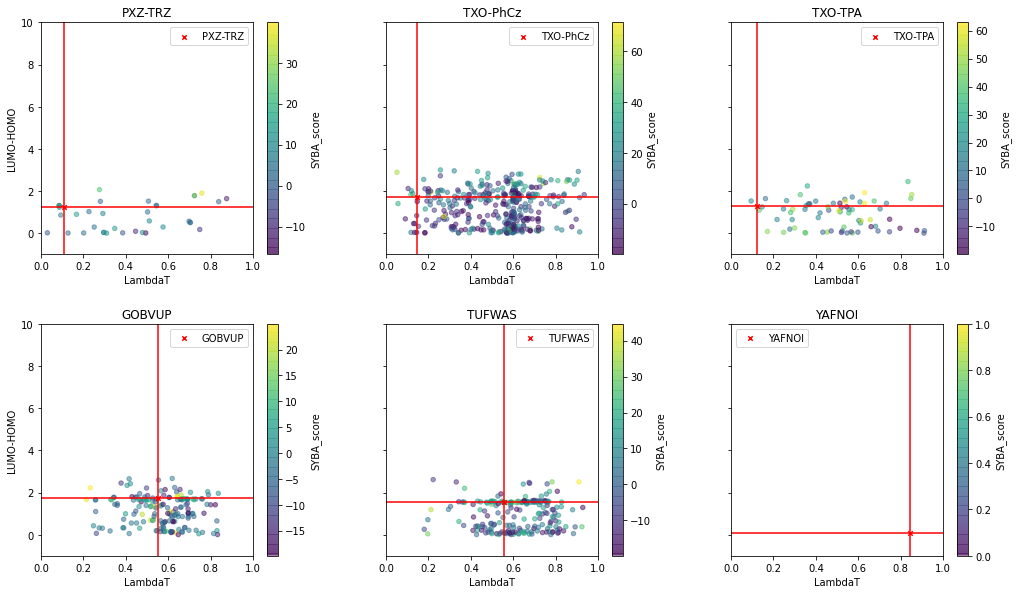

In [30]:
# need sublot and ax to solve bug relating to missing x ticks/labels
fig, axs = plt.subplots(nrows=2,ncols=3,figsize=(14,8), sharey=True)
fig.tight_layout()

counter = 0

for i,col in enumerate(df_og['Mol_names']):
    if i <= 1:
        for j,col2 in enumerate(df_og['Mol_names']):
            if j >= 3:
                break
            else:
#                 print(i,j)
                fam = df_og['Mol_names'][counter]
                axs[i,j].title.set_text(fam)
                axs[i,j].set_ylim(-1,10)
                
                df= df5.query('Family == @fam')
                df.plot.scatter(x='LambdaT',y='LUMO-HOMO',c='SYBA_score',colormap='viridis',ax=axs[i,j], alpha=0.5)
                df_og.query(f'Family == "{fam}"').plot.scatter(x='LambdaT',y='LUMO-HOMO',ax=axs[i,j], alpha=1,marker='x',label=fam,color='r')
                
            
                axs[i,j].axvline(x=df_og.query(f'Family == "{fam}"')['LambdaT'].values,color='r',label='Parent molecule')
                axs[i,j].axhline(y=df_og.query(f'Family == "{fam}"')['LUMO-HOMO'].values,color='r',label='Parent molecule')
                
                axs[i,j].set_xlim([0, 1])
                
                counter +=1
        
fig.subplots_adjust(hspace=0.3)
fig.subplots_adjust(wspace=0.3)
plt.show()

In [31]:
# need sublot and ax to solve bug relating to missing x ticks/labels
fig, axs = plt.subplots(nrows=2,ncols=3,figsize=(14,8), sharey=True)
fig.tight_layout()

counter = 0

for i,col in enumerate(df_og['Mol_names']):
    if i <= 1:
        for j,col2 in enumerate(df_og['Mol_names']):
#             print(i,j)
            if j >= 3:
                break
            else:
                fam = df_og['Mol_names'][counter]
                og_lambdaT = df_og['LambdaT'][counter]
                og_HL = df_og['LUMO-HOMO'][counter]
                
                counter +=1
                
                axs[i,j].title.set_text(fam)
                axs[i,j].set_ylim(-1,10)
                
                df = df5.query('Family == @fam').query("LambdaT <= @og_lambdaT").query("LUMO-HOMO <= @og_HL").query('shell == "closed"')
                
                n_mols = df.shape[0]
                
                if n_mols < 10:
                    n_needed_mols = 10 - n_mols
#                     print(fam,counter)
                    df_additional = df5.query('Family == @fam').query('shell == "closed"').query("LUMO-HOMO <= @og_HL").query("LambdaT > @og_lambdaT").sort_values('LambdaT').head(n_needed_mols)
                    df_additional.plot.scatter(x='LambdaT',y='LUMO-HOMO',c='SYBA_score',colormap='viridis',colorbar=False,ax=axs[i,j], alpha=0.5,marker='x')
                
                
                df.plot.scatter(x='LambdaT',y='LUMO-HOMO',c='SYBA_score',colormap='viridis',ax=axs[i,j], alpha=0.5)
                df_og.query(f'Family == "{fam}"').plot.scatter(x='LambdaT',y='LUMO-HOMO',ax=axs[i,j], alpha=1,marker='x',label=fam,color='r')
                
            
                axs[i,j].axvline(x=df_og.query(f'Family == "{fam}"')['LambdaT'].values,color='r',label='Parent molecule')
                axs[i,j].axhline(y=df_og.query(f'Family == "{fam}"')['LUMO-HOMO'].values,color='r',label='Parent molecule')
                
                axs[i,j].set_xlim([0, 1])
        
fig.subplots_adjust(hspace=0.3)
fig.subplots_adjust(wspace=0.3)
plt.show()

### HL, HL overlap and  FP score

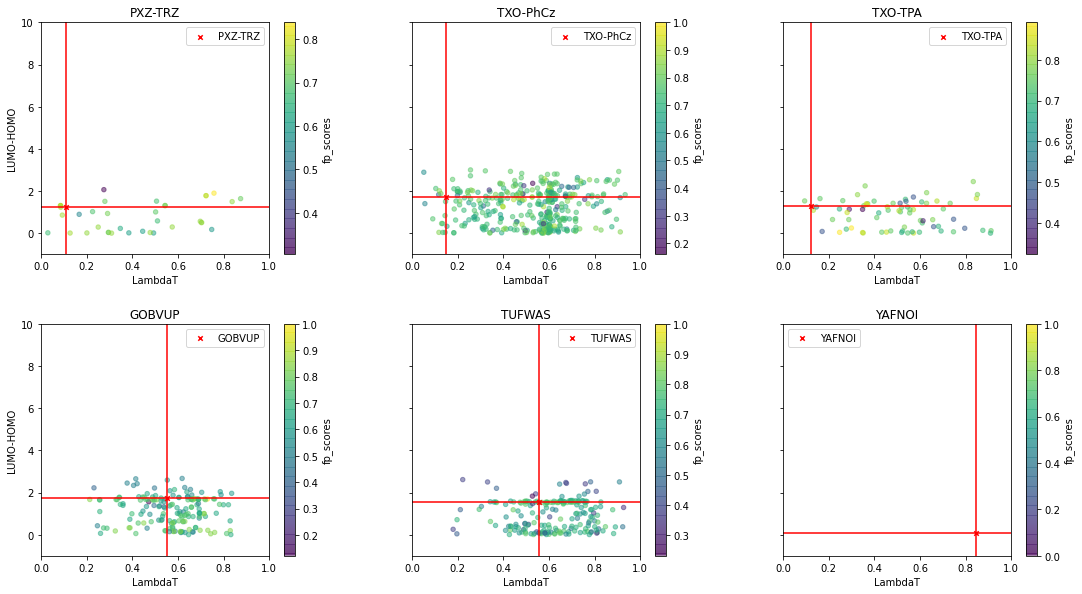

In [32]:
# need sublot and ax to solve bug relating to missing x ticks/labels
fig, axs = plt.subplots(nrows=2,ncols=3,figsize=(15,8), sharey=True)
fig.tight_layout()

counter = 0

for i,col in enumerate(df_og['Mol_names']):
    if i <= 1:
        for j,col2 in enumerate(df_og['Mol_names']):
            if j >= 3:
                break
            else:
#                 print(i,j)
                fam = df_og['Mol_names'][counter]
                axs[i,j].title.set_text(fam)
                axs[i,j].set_ylim(-1,10)
                
                df= df5.query(f'Family == "{fam}"')
                df.plot.scatter(x='LambdaT',y='LUMO-HOMO',c='fp_scores',colormap='viridis',ax=axs[i,j], alpha=0.5)
                df_og.query(f'Family == "{fam}"').plot.scatter(x='LambdaT',y='LUMO-HOMO',ax=axs[i,j], alpha=1,marker='x',label=fam,color='r')
                
                axs[i,j].axvline(x=df_og.query(f'Family == "{fam}"')['LambdaT'].values,color='r',label='Parent molecule')
                axs[i,j].axhline(y=df_og.query(f'Family == "{fam}"')['LUMO-HOMO'].values,color='r',label='Parent molecule')
                
                axs[i,j].set_xlim([0, 1])
                
                counter +=1
        
fig.subplots_adjust(hspace=0.3)
fig.subplots_adjust(wspace=0.3)
plt.show()

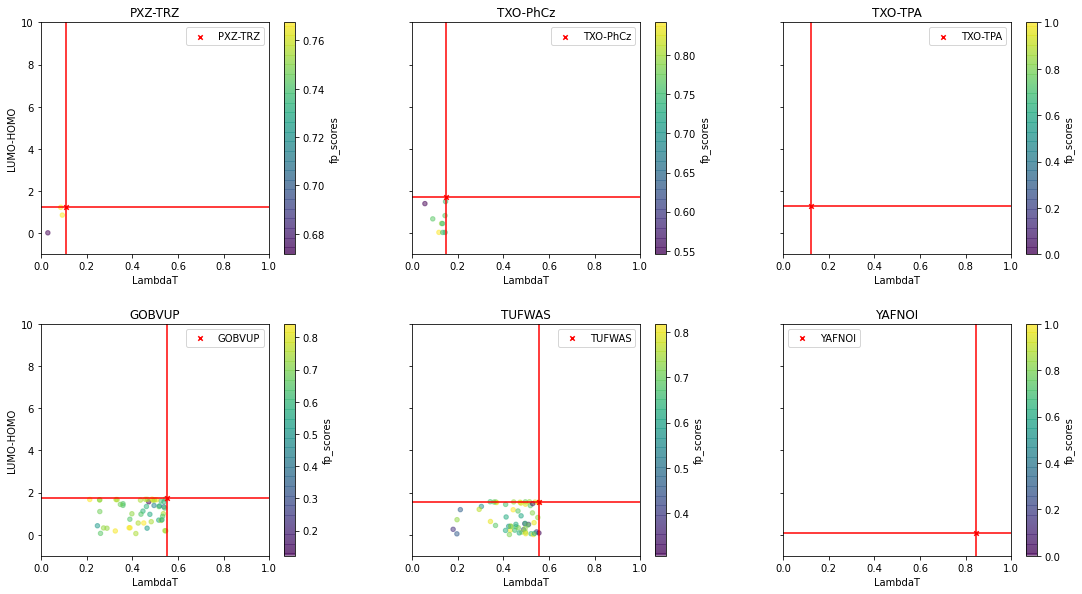

In [33]:
# need sublot and ax to solve bug relating to missing x ticks/labels
fig, axs = plt.subplots(nrows=2,ncols=3,figsize=(15,8), sharey=True)
fig.tight_layout()

counter = 0

for i,col in enumerate(df_og['Mol_names']):
    if i <= 1:
        for j,col2 in enumerate(df_og['Mol_names']):
            if j >= 3:
                break
            else:
#                 print(i,j)
                fam = df_og['Mol_names'][counter]
                og_lambdaT = df_og['LambdaT'][counter]
                og_HL = df_og['LUMO-HOMO'][counter]
                axs[i,j].title.set_text(fam)
                axs[i,j].set_ylim(-1,10)
                
                df= df5.query('Family == @fam').query("LambdaT <= @og_lambdaT").query("LUMO-HOMO <= @og_HL")
                df.plot.scatter(x='LambdaT',y='LUMO-HOMO',c='fp_scores',colormap='viridis',ax=axs[i,j], alpha=0.5)
                df_og.query(f'Family == "{fam}"').plot.scatter(x='LambdaT',y='LUMO-HOMO',ax=axs[i,j], alpha=1,marker='x',label=fam,color='r')
                
                axs[i,j].axvline(x=df_og.query(f'Family == "{fam}"')['LambdaT'].values,color='r',label='Parent molecule')
                axs[i,j].axhline(y=df_og.query(f'Family == "{fam}"')['LUMO-HOMO'].values,color='r',label='Parent molecule')
                
                axs[i,j].set_xlim([0, 1])
                
                counter +=1
        
fig.subplots_adjust(hspace=0.3)
fig.subplots_adjust(wspace=0.3)
plt.show()

# TRANSFER CHOSEN XYZ FILES

In [34]:
df6_open = df5.query('shell == "open"')
df6_closed = df5.query('shell == "closed"')

print('closed', len(df6_closed),len(df6_closed)/(len(df6_closed)+len(df6_open))*100,'%', 'open', len(df6_open),100*len(df6_open)/(len(df6_closed)+len(df6_open)),'%')

closed 488 57.009345794392516 % open 368 42.99065420560748 %


what about for each case?

In [36]:
atom_thresh = 10
mols_for_geopt = []
for i,mol in enumerate(df_og['Mol_names']):
    if mol != 'YAFNOI':
        og_natoms = int(df_og['N_atoms'][i])

        fam = df_og['Mol_names'][i]
        og_lambdaT = df_og['LambdaT'][i]
        og_HL = df_og['LUMO-HOMO'][i]

        df = df5.query('Family == @mol').query("LambdaT <= @og_lambdaT").query("LUMO-HOMO <= @og_HL").query('shell == "closed"')
        n_mols = df.shape[0]

        if n_mols < 10:

            n_needed_mols = 10 - n_mols

            df_additional = df5.query('Family == @fam').query('shell == "closed"').query("LUMO-HOMO <= @og_HL").query("LambdaT > @og_lambdaT").sort_values('LambdaT').head(n_needed_mols)
            df = df.append(df_additional)
        print(df.shape)

        for mol in df['Mol_names']:
            all_mols_dir_path = '/home/kt4218/workspace/PhD_final/HOMO_LUMO_density/calculation_cube/mols_gen_UPDATED_161121'
            for file in os.listdir(all_mols_dir_path):
                if mol+".xyz" == file:
#                     print(mol, file)
                    mols_for_geopt.append(mol)
                    shutil.copy(all_mols_dir_path+'/'+file,'GEOPT_all_mols_PART6_generate_inps/mols_gen_UPDATED_26042022/')

(10, 27)
(10, 27)
(10, 27)
(30, 27)
(32, 27)


In [39]:
# pickle.dump(mols_for_geopt, open("mols_for_geopt.pkl",'wb'))

# LUMO-HOMO

In [24]:
atom_cols = [column for column in df3.columns if 'Contain' in column]
atom_cols

['Contain_Br',
 'Contain_C',
 'Contain_Cl',
 'Contain_F',
 'Contain_H',
 'Contain_I',
 'Contain_N',
 'Contain_O',
 'Contain_P',
 'Contain_S']

### looking at atom specie

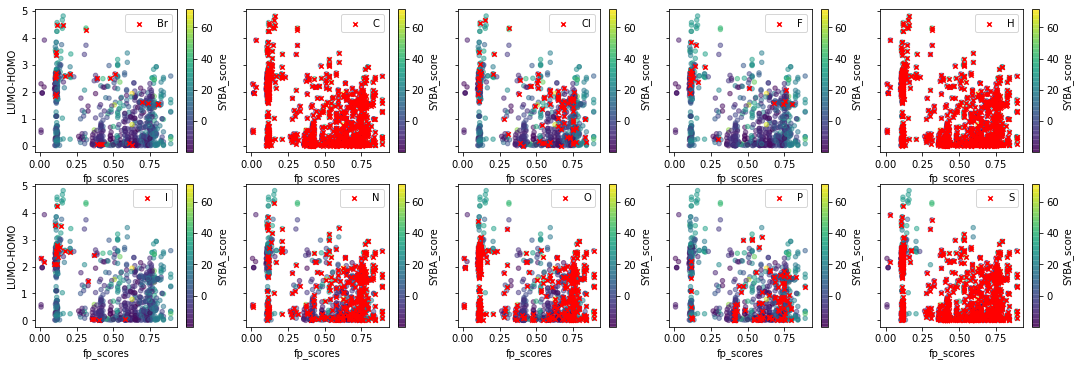

In [25]:
# need sublot and ax to solve bug relating to missing x ticks/labels

fig, axs = plt.subplots(nrows=2,ncols=5,figsize=(15,5), sharey=True)
fig.tight_layout()

counter = 0

for i,col in enumerate(atom_cols):
    if i <= 1:
        for j,col2 in enumerate(atom_cols):
            if j >= 5:
                break
            else:
                df3.plot.scatter(x='fp_scores',y='LUMO-HOMO',c='SYBA_score',colormap='viridis',ax=axs[i,j], alpha=0.5)
                column_name = atom_cols[counter]
                label = column_name.replace('Contain_','')
                df3[df3[column_name].notnull()].plot.scatter(x='fp_scores',y='LUMO-HOMO', marker = 'x',ax=axs[i,j],color='r',label=label)
                # plt.axhline(y=og_smi_sybascores[name],color='r',label='Parent molecule')
                counter +=1
plt.show()

PXZ-TRZ


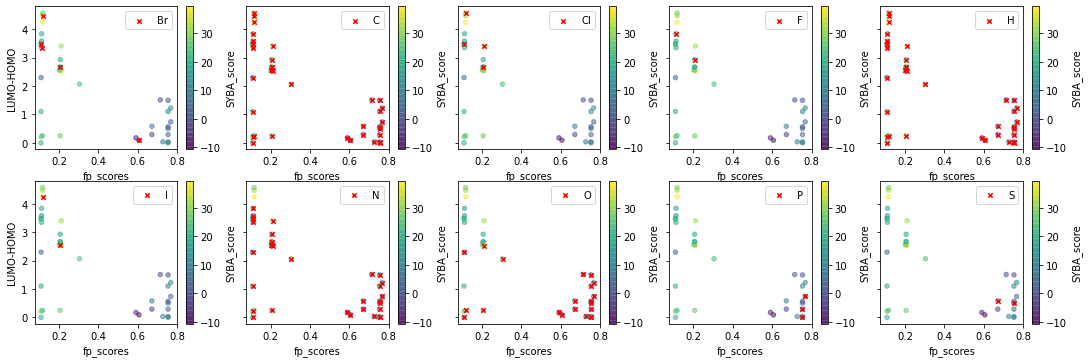

TXO-PhCz


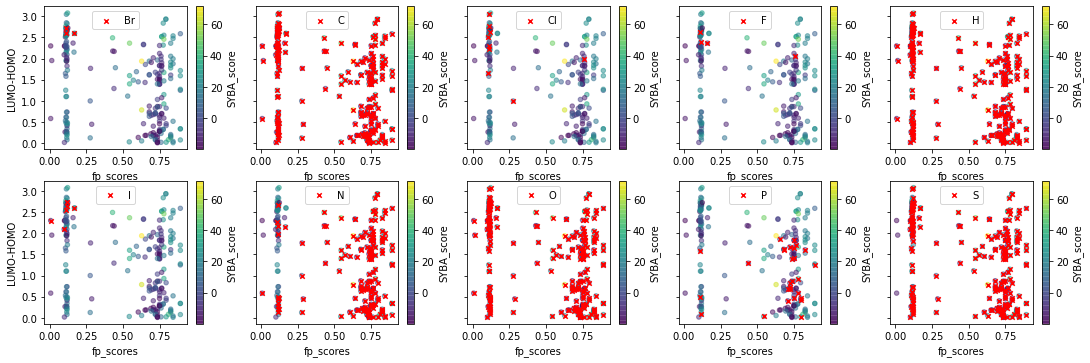

TXO-TPA


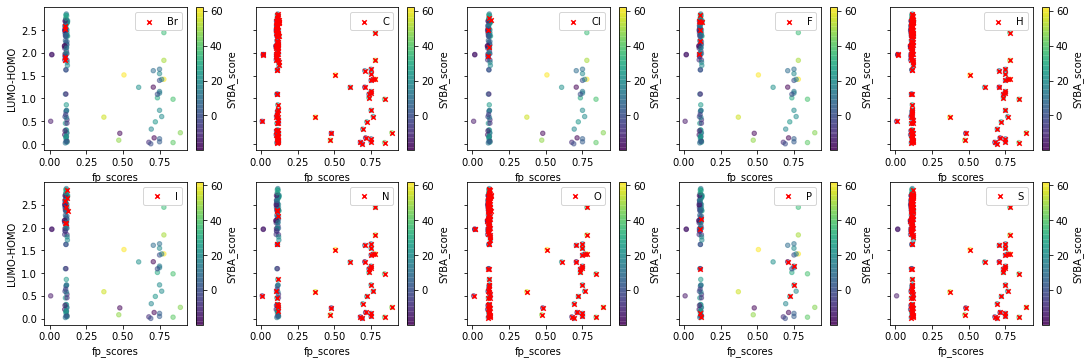

GOBVUP


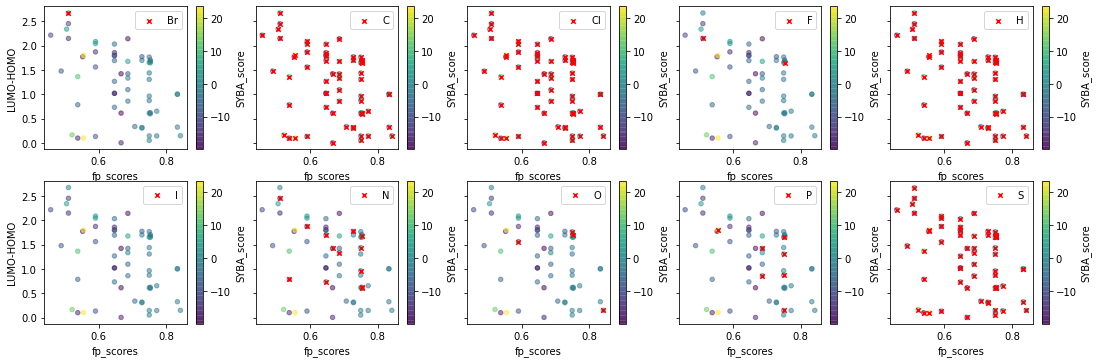

TUFWAS


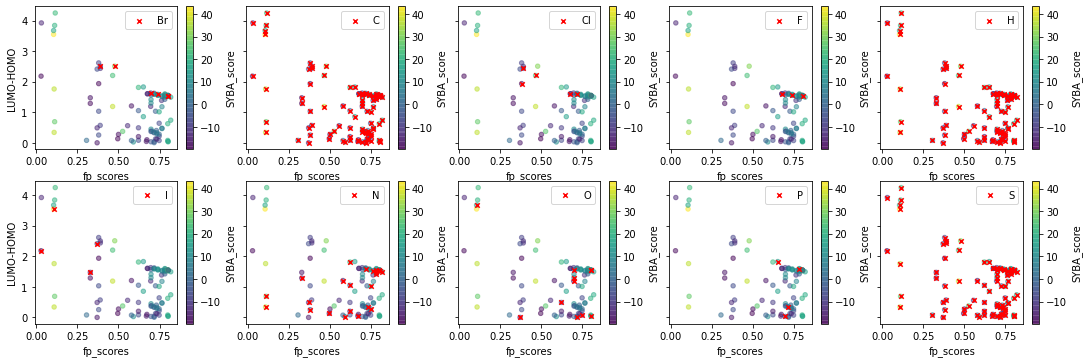

YAFNOI


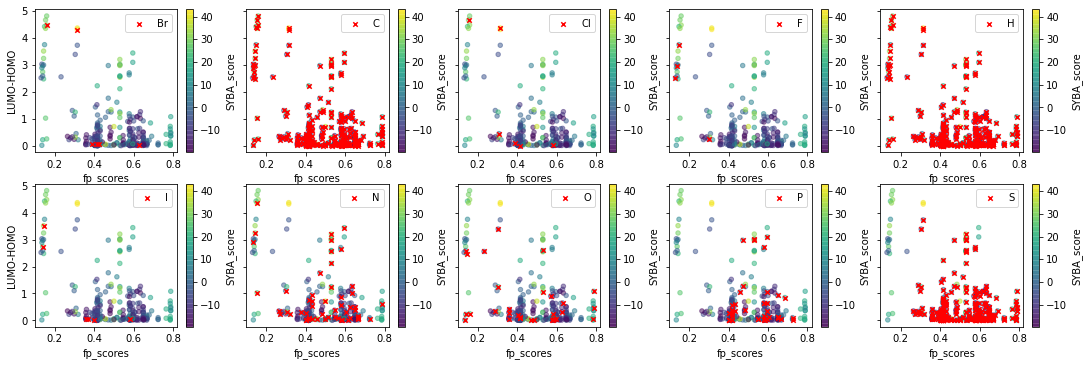

In [26]:
# need sublot and ax to solve bug relating to missing x ticks/labels

for fam in df_og['Mol_names']:
    print(fam)
    fig, axs = plt.subplots(nrows=2,ncols=5,figsize=(15,5), sharey=True)
    fig.tight_layout()

    counter = 0

    for i,col in enumerate(atom_cols):
        if i <= 1:
            for j,col2 in enumerate(atom_cols):
                if j >= 5:
                    break
                else:
                    df = df3.query(f'Family == "{fam}"')
                    df.plot.scatter(x='fp_scores',y='LUMO-HOMO',c='SYBA_score',colormap='viridis',ax=axs[i,j], alpha=0.5)
                    column_name = atom_cols[counter]
                    label = column_name.replace('Contain_','')
                    df[df[column_name].notnull()].plot.scatter(x='fp_scores',y='LUMO-HOMO', marker = 'x',ax=axs[i,j],color='r',label=label)
                    # plt.axhline(y=og_smi_sybascores[name],color='r',label='Parent molecule')
                    counter +=1
    plt.show()

#### Get rid of C, H

In [27]:
atom_cols2 = [atom for atom in atom_cols if (atom != 'Contain_C' and atom != 'Contain_H')]
atom_cols2

['Contain_Br',
 'Contain_Cl',
 'Contain_F',
 'Contain_I',
 'Contain_N',
 'Contain_O',
 'Contain_P',
 'Contain_S']

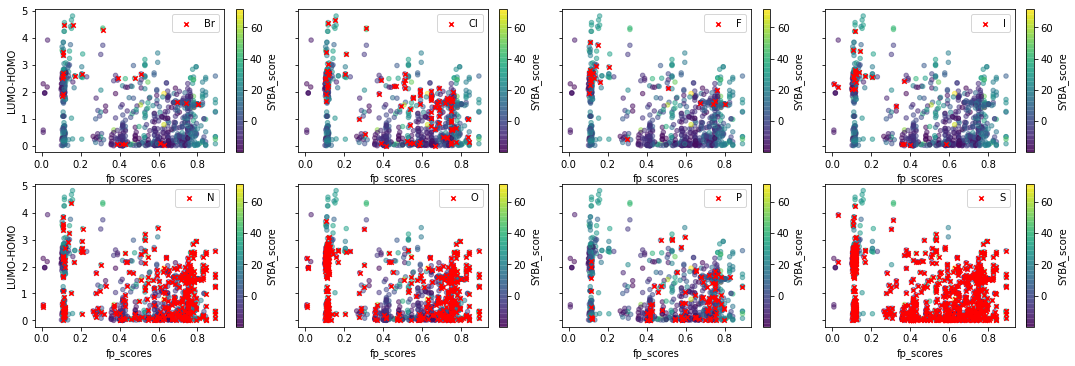

In [28]:
# need sublot and ax to solve bug relating to missing x ticks/labels

fig, axs = plt.subplots(nrows=2,ncols=4,figsize=(15,5), sharey=True)
fig.tight_layout()

counter = 0

for i,col in enumerate(atom_cols2):
    if i <= 1:
        for j,col2 in enumerate(atom_cols2):
            if j >= 4:
                break
            else:
                df3.plot.scatter(x='fp_scores',y='LUMO-HOMO',c='SYBA_score',colormap='viridis',ax=axs[i,j], alpha=0.5)
                column_name = atom_cols2[counter]
                label = column_name.replace('Contain_','')
#                 df3.plot.scatter(x='SYBA_score',y='LUMO-HOMO',c='fp_scores',colormap='viridis',ax=axs[i,j], alpha=0.5)
                df3[df3[column_name].notnull()].plot.scatter(x='fp_scores',y='LUMO-HOMO', marker = 'x',ax=axs[i,j],color='r',label=label)
                # plt.axhline(y=og_smi_sybascores[name],color='r',label='Parent molecule')
                counter +=1
plt.show()

PXZ-TRZ


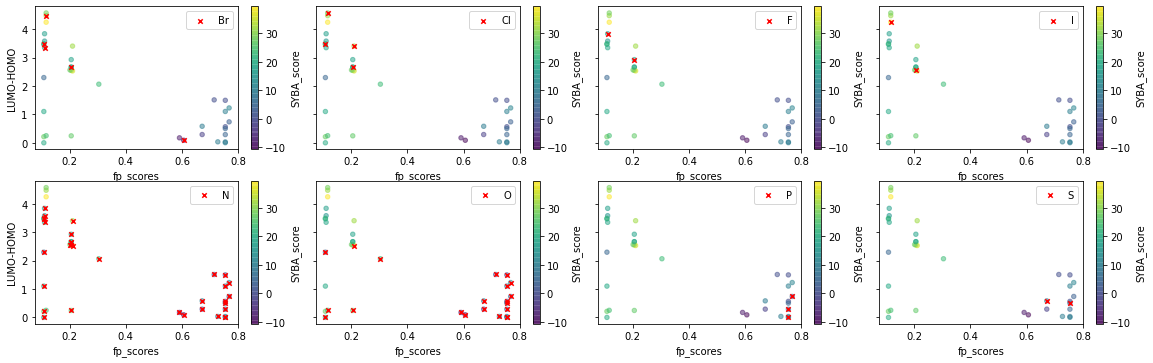

TXO-PhCz


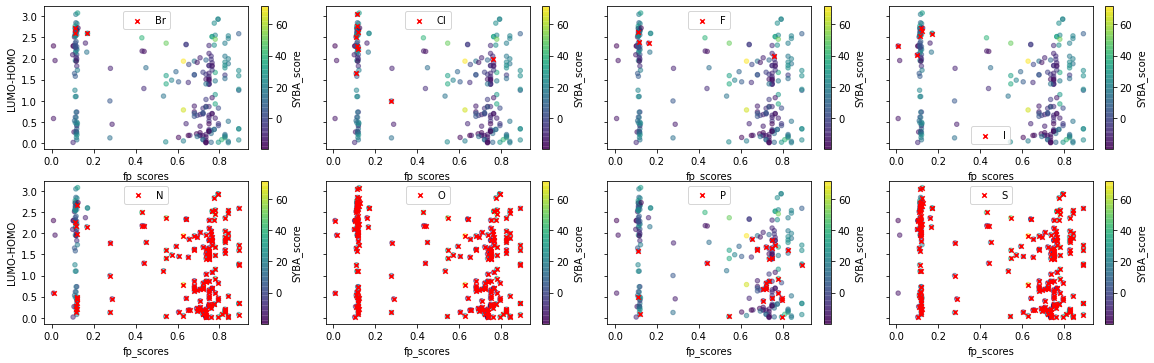

TXO-TPA


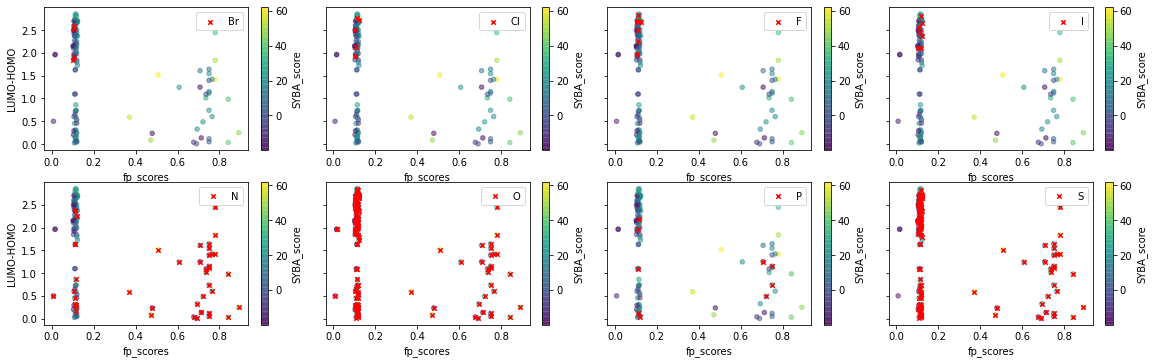

GOBVUP


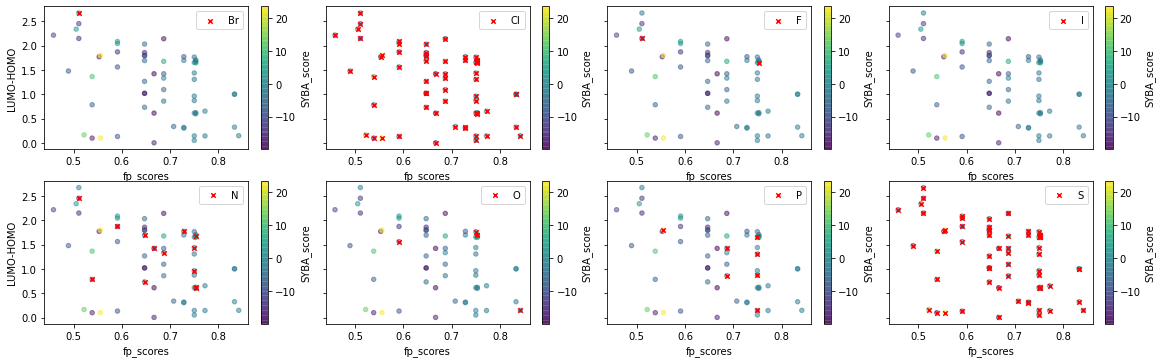

TUFWAS


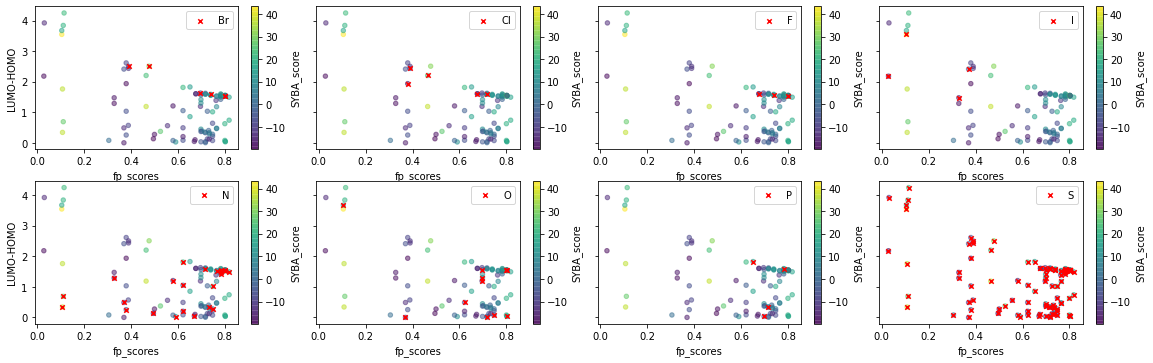

YAFNOI


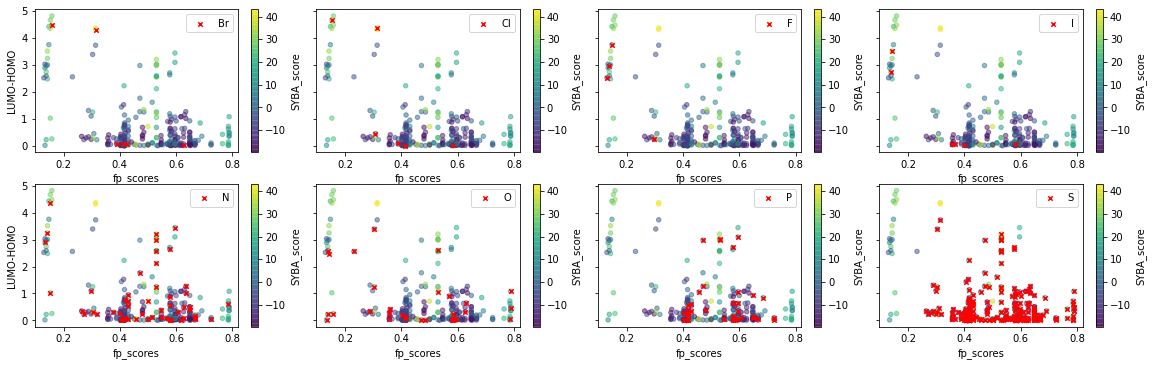

In [133]:
# need sublot and ax to solve bug relating to missing x ticks/labels

for fam in df_og['Mol_names']:
    print(fam)
    fig, axs = plt.subplots(nrows=2,ncols=4,figsize=(16,5), sharey=True)
    fig.tight_layout()

    counter = 0

    for i,col in enumerate(atom_cols2):
        if i <= 1:
            for j,col2 in enumerate(atom_cols2):
                if j >= 4:
                    break
                else:
                    df = df3.query(f'Family == "{fam}"')
                    df.plot.scatter(x='fp_scores',y='LUMO-HOMO',c='SYBA_score',colormap='viridis',ax=axs[i,j], alpha=0.5)
                    column_name = atom_cols2[counter]
                    label = column_name.replace('Contain_','')
                    df[df[column_name].notnull()].plot.scatter(x='fp_scores',y='LUMO-HOMO', marker = 'x',ax=axs[i,j],color='r',label=label)
                    # plt.axhline(y=og_smi_sybascores[name],color='r',label='Parent molecule')
                    counter +=1
    plt.show()

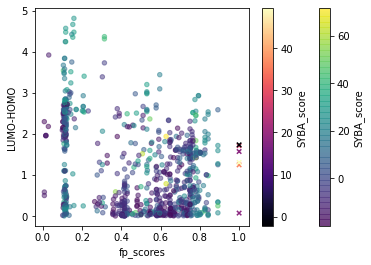

In [137]:
# need sublot and ax to solve bug relating to missing x ticks/labels
fig, ax = plt.subplots()
df3.plot.scatter(x='fp_scores',y='LUMO-HOMO',c='SYBA_score',colormap='viridis',ax=ax, alpha=0.5)
df_og.plot.scatter(x='fp_scores',y='LUMO-HOMO',c='SYBA_score',colormap='magma',ax=ax, alpha=1,marker='x')
plt.show()

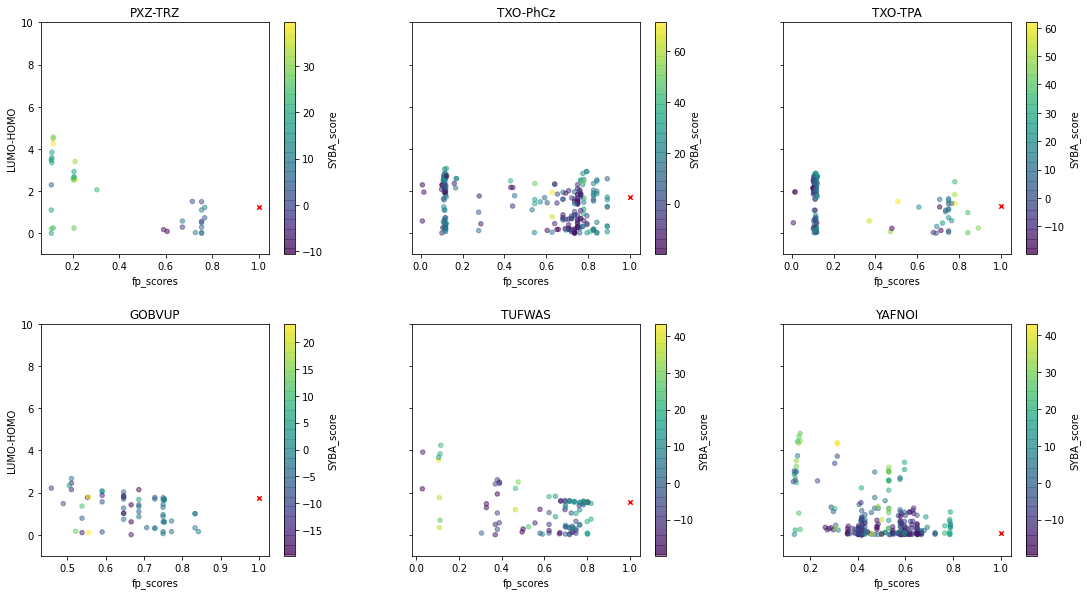

In [146]:
# need sublot and ax to solve bug relating to missing x ticks/labels
fig, axs = plt.subplots(nrows=2,ncols=3,figsize=(15,8), sharey=True)
fig.tight_layout()

counter = 0

for i,col in enumerate(df_og['Mol_names']):
    if i <= 1:
        for j,col2 in enumerate(df_og['Mol_names']):
            if j >= 3:
                break
            else:
#                 print(i,j)
                fam = df_og['Mol_names'][counter]
                axs[i,j].title.set_text(fam)
                axs[i,j].set_ylim(-1,10)
                
                df= df3.query(f'Family == "{fam}"')
#                 df.plot.scatter(x='$\Lambda_{\mathrm{T}}$',y='LUMO-HOMO',c='fp_scores',colormap='viridis',ax=axs[i,j], alpha=0.5)
#                 df_og.query(f'Family == "{fam}"').plot.scatter(x='$\Lambda_{\mathrm{T}}$',y='LUMO-HOMO',ax=axs[i,j], alpha=1,marker='x',label=fam,color='r')
                
                df.plot.scatter(x='fp_scores',y='LUMO-HOMO',c='SYBA_score',colormap='viridis',ax=axs[i,j], alpha=0.5)
                df_og.query(f'Family == "{fam}"').plot.scatter(x='fp_scores',y='LUMO-HOMO',ax=axs[i,j], alpha=1,marker='x',color='r')
                
                counter +=1
        
fig.subplots_adjust(hspace=0.3)
fig.subplots_adjust(wspace=0.3)
plt.show()

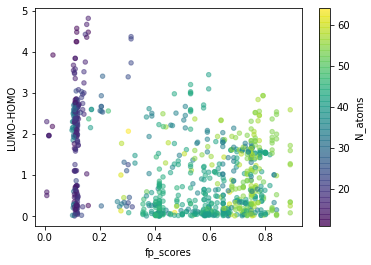

In [148]:
# need sublot and ax to solve bug relating to missing x ticks/labels
fig, ax = plt.subplots()
df3.plot.scatter(x='fp_scores',y='LUMO-HOMO',c='N_atoms',colormap='viridis',ax=ax, alpha=0.5)
plt.show()

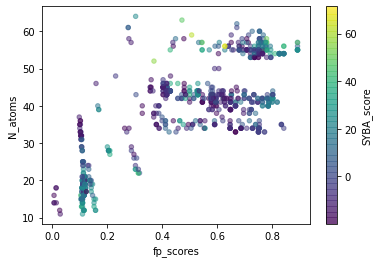

In [149]:
# need sublot and ax to solve bug relating to missing x ticks/labels
fig, ax = plt.subplots()
df3.plot.scatter(x='fp_scores',y='N_atoms',c='SYBA_score',colormap='viridis',ax=ax, alpha=0.5)
plt.show()

# Total Energy

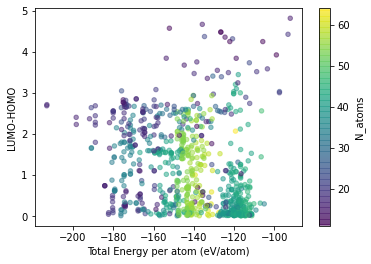

In [157]:
# need sublot and ax to solve bug relating to missing x ticks/labels
fig, ax = plt.subplots()
df3.plot.scatter(x='Total Energy per atom (eV/atom)',y='LUMO-HOMO',c='N_atoms',colormap='viridis',ax=ax, alpha=0.5)
plt.show()

# Forces

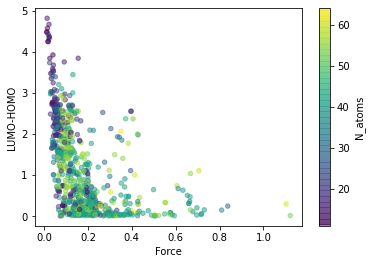

In [159]:
# need sublot and ax to solve bug relating to missing x ticks/labels
fig, ax = plt.subplots()
df3.plot.scatter(x='Force',y='LUMO-HOMO',c='N_atoms',colormap='viridis',ax=ax, alpha=0.5)
plt.show()

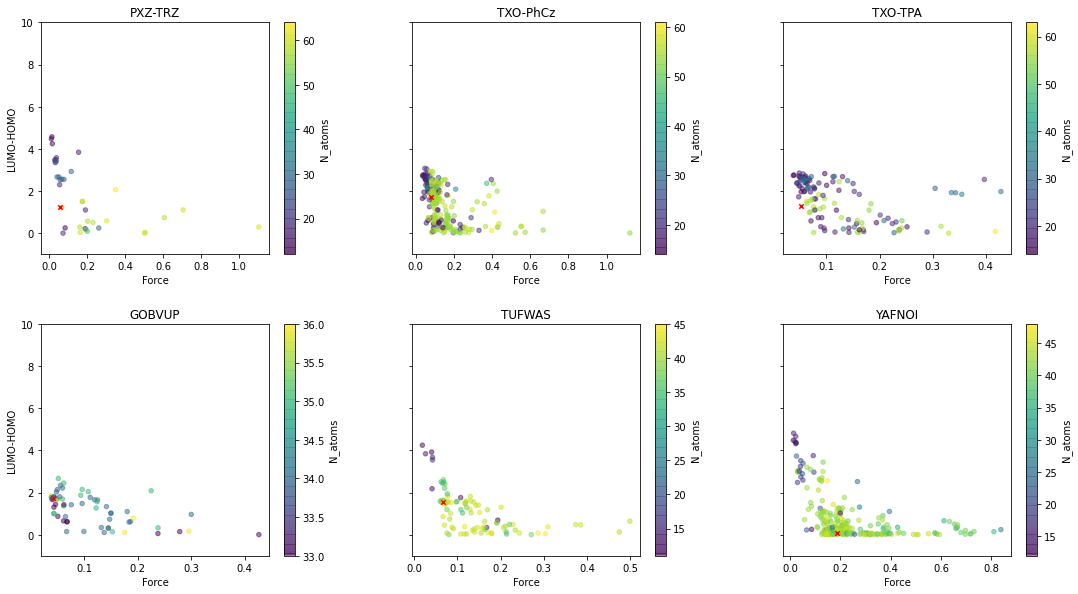

In [162]:
# need sublot and ax to solve bug relating to missing x ticks/labels
fig, axs = plt.subplots(nrows=2,ncols=3,figsize=(15,8), sharey=True)
fig.tight_layout()

counter = 0

for i,col in enumerate(df_og['Mol_names']):
    if i <= 1:
        for j,col2 in enumerate(df_og['Mol_names']):
            if j >= 3:
                break
            else:
#                 print(i,j)
                fam = df_og['Mol_names'][counter]
                axs[i,j].title.set_text(fam)
                axs[i,j].set_ylim(-1,10)
                
                df= df3.query(f'Family == "{fam}"')                
#                 df.plot.scatter(x='fp_scores',y='LUMO-HOMO',c='SYBA_score',colormap='viridis',ax=axs[i,j], alpha=0.5)
                df.plot.scatter(x='Force',y='LUMO-HOMO',c='N_atoms',colormap='viridis',ax=axs[i,j], alpha=0.5)
                df_og.query(f'Family == "{fam}"').plot.scatter(x='Force',y='LUMO-HOMO',ax=axs[i,j], alpha=1,marker='x',color='r')
                
                counter +=1
        
fig.subplots_adjust(hspace=0.3)
fig.subplots_adjust(wspace=0.3)
plt.show()

0     PXZ-TRZ
1    TXO-PhCz
2     TXO-TPA
3      GOBVUP
4      TUFWAS
5      YAFNOI
Name: Mol_names, dtype: object